In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_traffic_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    cast_to_float,
)

from src.evaluation import evaluate

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
dataframe = load_traffic_data()
print(f"dataframe shape {dataframe.shape}")
print(dataframe.info())
dataframe.head()

dataframe shape (48204, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB
None


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
def encode_holiday(dataframe):
    dataframe["holiday"] = dataframe["holiday"].apply(lambda x: 1 if x != "None" else 0)
    return dataframe


dataframe = (
    load_traffic_data()
    .pipe(format_datetime, col="date_time")
    .pipe(set_index, col="date_time")
    .pipe(
        select_column,
        cols=[
            "holiday",
            "temp",
            "rain_1h",
            "snow_1h",
            "clouds_all",
            "traffic_volume",
        ],
    )
    .pipe(encode_holiday)
    .pipe(fill_missing_dates, freq="H")
    .pipe(resample_Data, freq="3H")
    # .pipe(replace_null)
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (48204, 9)
set_index: DF Shape (48204, 8)
select_column: DF Shape (48204, 6)
fill_missing_dates: DF Shape (52551, 6)
resample_Data: DF Shape (17517, 6)
dataframe shape (17517, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17517 entries, 2012-10-02 09:00:00 to 2018-09-30 21:00:00
Freq: 3H
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         17517 non-null  float64
 1   temp            17517 non-null  float64
 2   rain_1h         17517 non-null  float64
 3   snow_1h         17517 non-null  float64
 4   clouds_all      17517 non-null  float64
 5   traffic_volume  17517 non-null  float64
dtypes: float64(6)
memory usage: 958.0 KB
None


,holiday,temp,rain_1h,snow_1h,clouds_all,traffic_volume
date_time,,,,,,
2012-10-02 09:00:00,0.0,289.073333,0.0,0.0,68.333333,4942.666667
2012-10-02 12:00:00,0.0,290.996667,0.0,0.0,55.333333,5041.666667
2012-10-02 15:00:00,0.0,293.723333,0.0,0.0,7.333333,5796.666667
2012-10-02 18:00:00,0.0,291.150000,0.0,0.0,13.666667,3697.666667
2012-10-02 21:00:00,0.0,287.073333,0.0,0.0,1.000000,1617.666667


In [5]:
dataframe.isna().sum()

holiday           0
temp              0
rain_1h           0
snow_1h           0
clouds_all        0
traffic_volume    0
dtype: int64

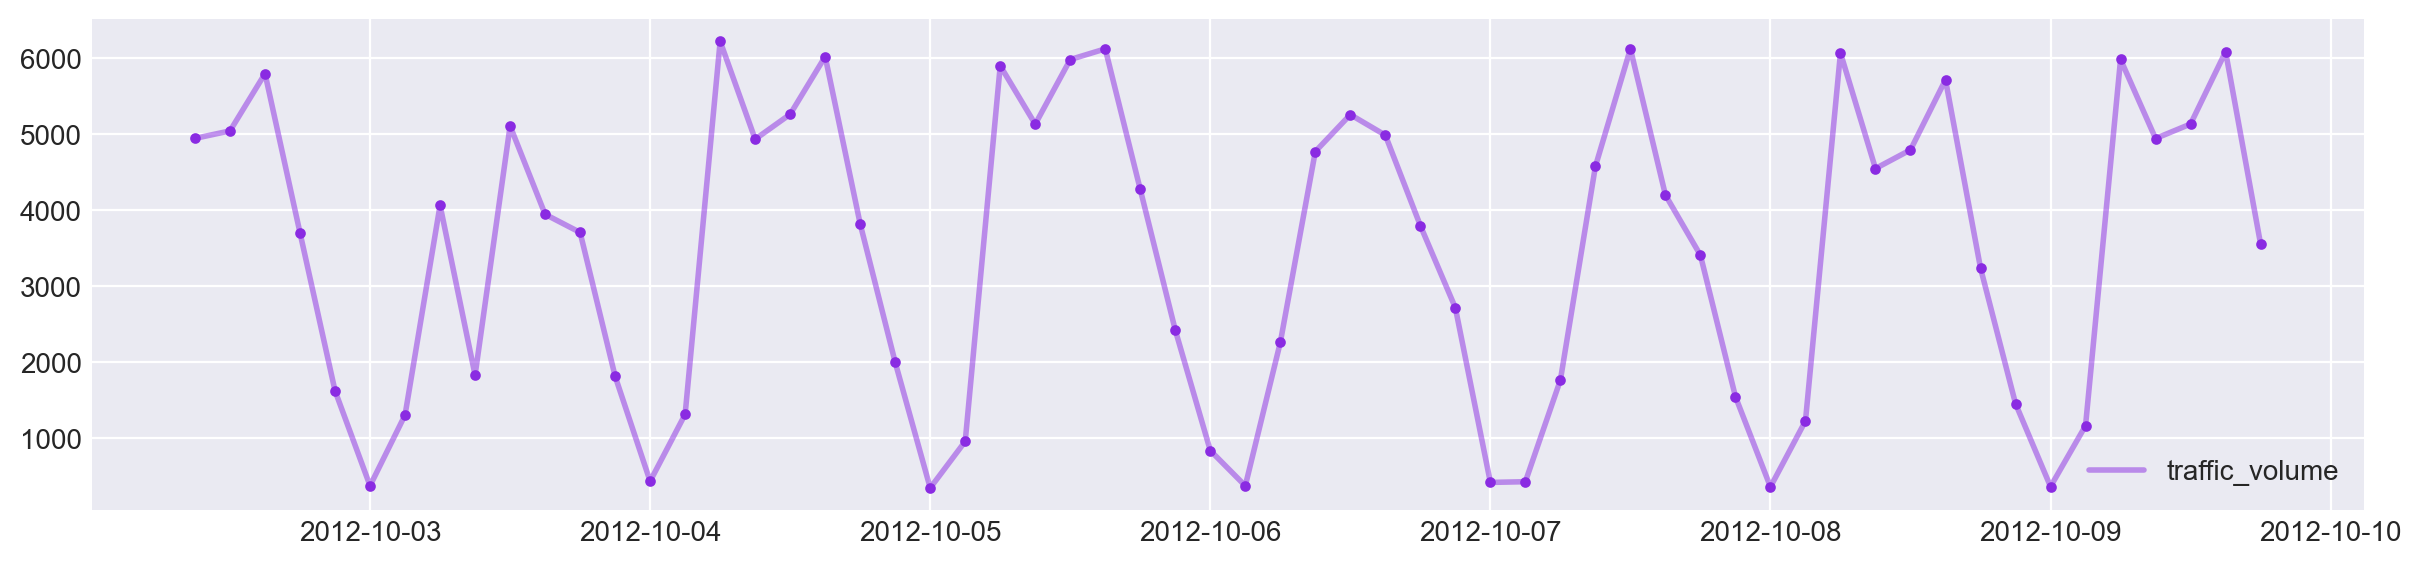

In [6]:
show_dataset(dataframe[:60], columns=["traffic_volume"])

In [7]:
dt_features = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
cl_features = ["day", "month", "year"]
lags = [1, 2]
window_length = 3

target_column = "traffic_volume"
TEST_SIZE = 30

In [8]:
train_data, test_data = test_train_split(dataframe, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)

train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

print(f"train_data shape after Feature Union {train_data_feat.shape}")
print(f"test_data shape after Feature Union {test_data_feat.shape}")

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)

print(f"train_data shape after Null Removal {train_data_feat.shape}")
print(f"test_data shape after Null Removal {test_data_feat.shape}")

train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

test_data_feat.head()

Train Size after Test_Train Split: (17487, 6)
Test  Size after Test_Train Split: (30, 6) 
train_data shape after Feature Union (17487, 25)
test_data shape after Feature Union (30, 25)
train_data shape after Null Removal (17485, 25)
test_data shape after Null Removal (30, 25)


,holiday,temp,rain_1h,snow_1h,clouds_all,traffic_volume,traffic_volume_lag_1,traffic_volume_lag_2,traffic_volume_mean_window_3,traffic_volume_std_window_3,...,dayofmonth,weekofyear,is_week_end,is_week_day,sin_day,cos_day,sin_month,cos_month,sin_year,cos_year
date_time,,,,,,,,,,,,,,,,,,,,,
2018-09-27 06:00:00,0.0,380.253333,0.000000,0.0,60.666667,8269.666667,8269.666667,8269.666667,5971.000000,1991.066381,...,27.0,39.0,0.0,1.0,0.956376,-0.292139,0.412118,-0.91113,-0.176046,0.984382
2018-09-27 09:00:00,0.0,286.256667,0.083333,0.0,90.000000,4783.666667,8269.666667,8269.666667,5971.000000,1991.066381,...,27.0,39.0,0.0,1.0,0.956376,-0.292139,0.412118,-0.91113,-0.176046,0.984382
2018-09-27 12:00:00,0.0,287.743333,0.000000,0.0,90.000000,4859.666667,4783.666667,8269.666667,5971.000000,1991.066381,...,27.0,39.0,0.0,1.0,0.956376,-0.292139,0.412118,-0.91113,-0.176046,0.984382
2018-09-27 15:00:00,0.0,288.333333,0.000000,0.0,55.333333,6103.666667,4859.666667,4783.666667,5249.000000,741.137864,...,27.0,39.0,0.0,1.0,0.956376,-0.292139,0.412118,-0.91113,-0.176046,0.984382
2018-09-27 18:00:00,0.0,286.720000,0.000000,0.0,61.666667,3591.000000,6103.666667,4859.666667,4851.444444,1256.353512,...,27.0,39.0,0.0,1.0,0.956376,-0.292139,0.412118,-0.91113,-0.176046,0.984382


In [9]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..........regressor__n_neighbors=2;, score=0.710 total time=   0.3s
[CV 2/3] END ..........regressor__n_neighbors=2;, score=0.560 total time=   0.3s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.744 total time=   0.5s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.728 total time=   0.1s
[CV 2/3] END ..........regressor__n_neighbors=3;, score=0.581 total time=   0.3s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.761 total time=   0.5s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.746 total time=   0.1s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.581 total time=   0.2s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.764 total time=   0.5s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.745 total time=   0.1s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.571 total time=   0.4s
[CV 3/3] END ..........regressor__n_neighbors=7;,

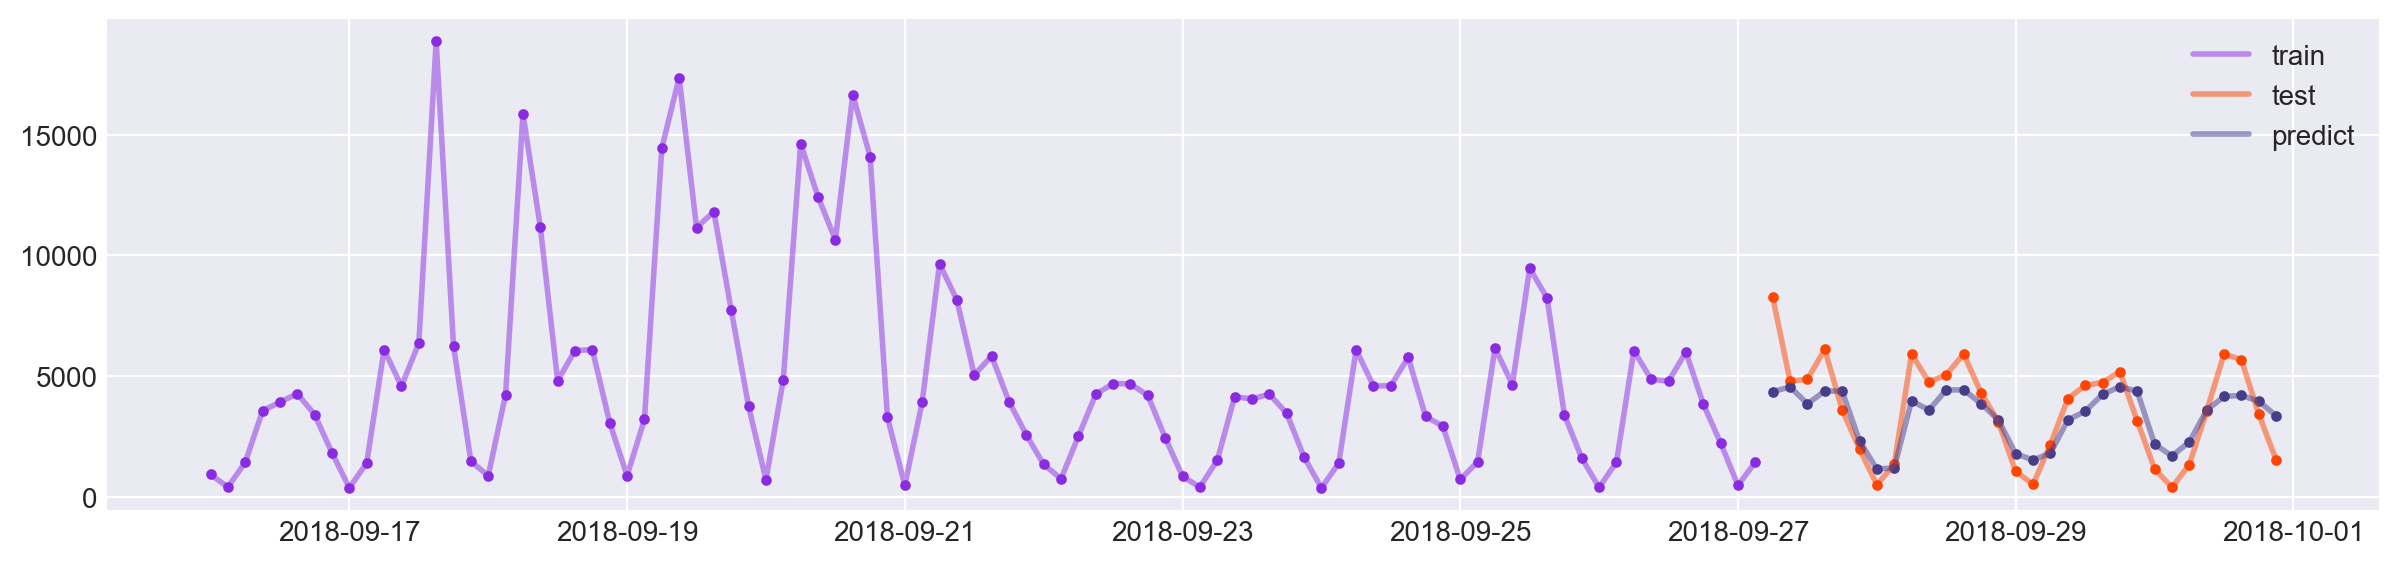

In [11]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [12]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  5  iterations


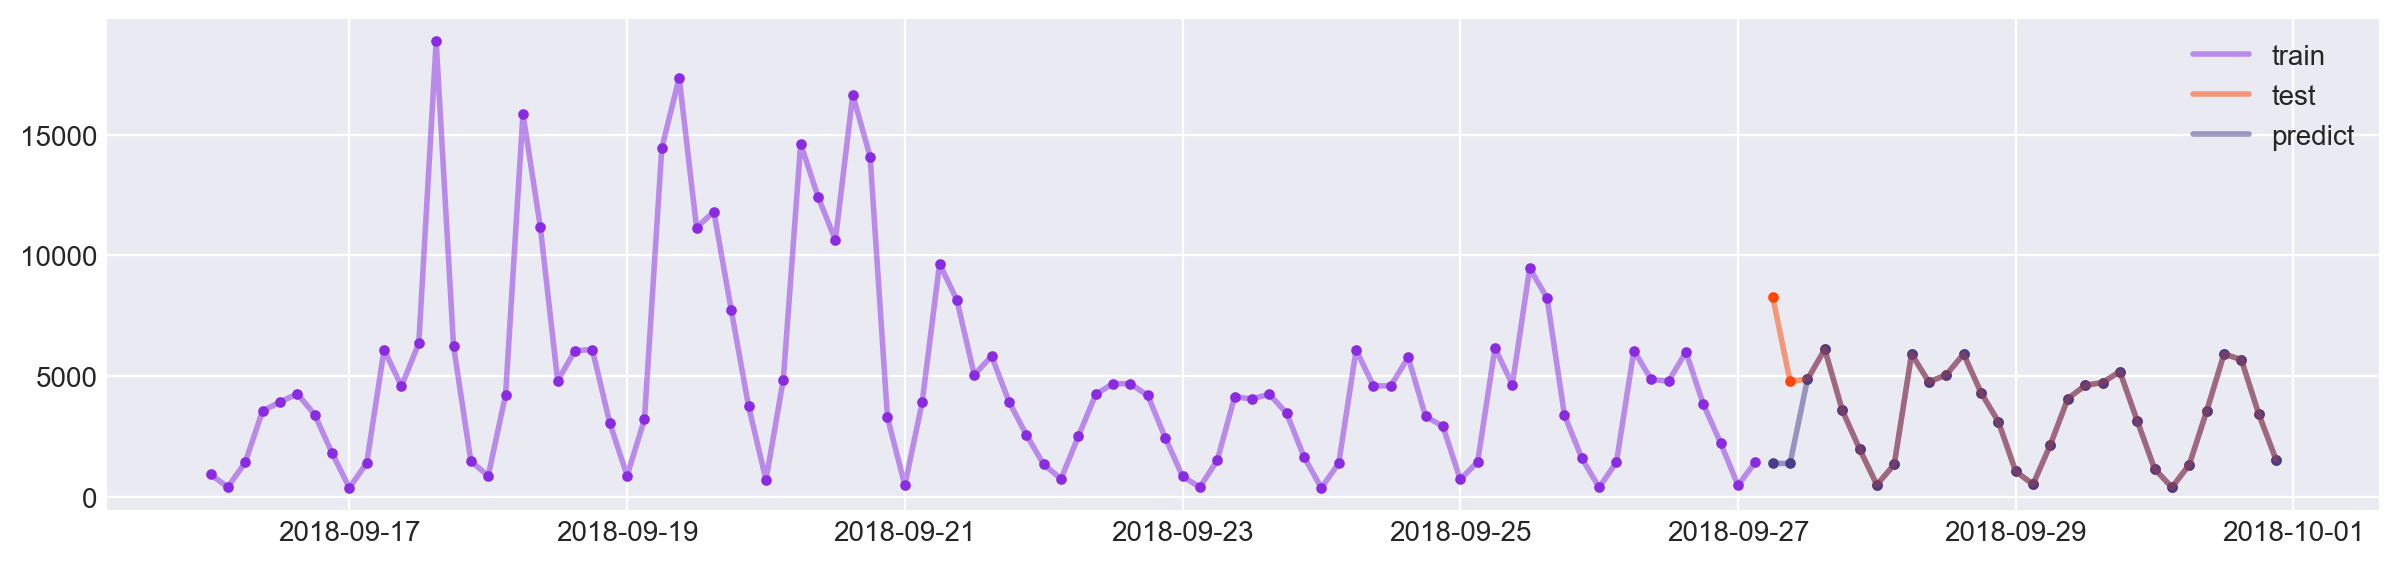

In [13]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [14]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LassoCV(fit_intercept=True))]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

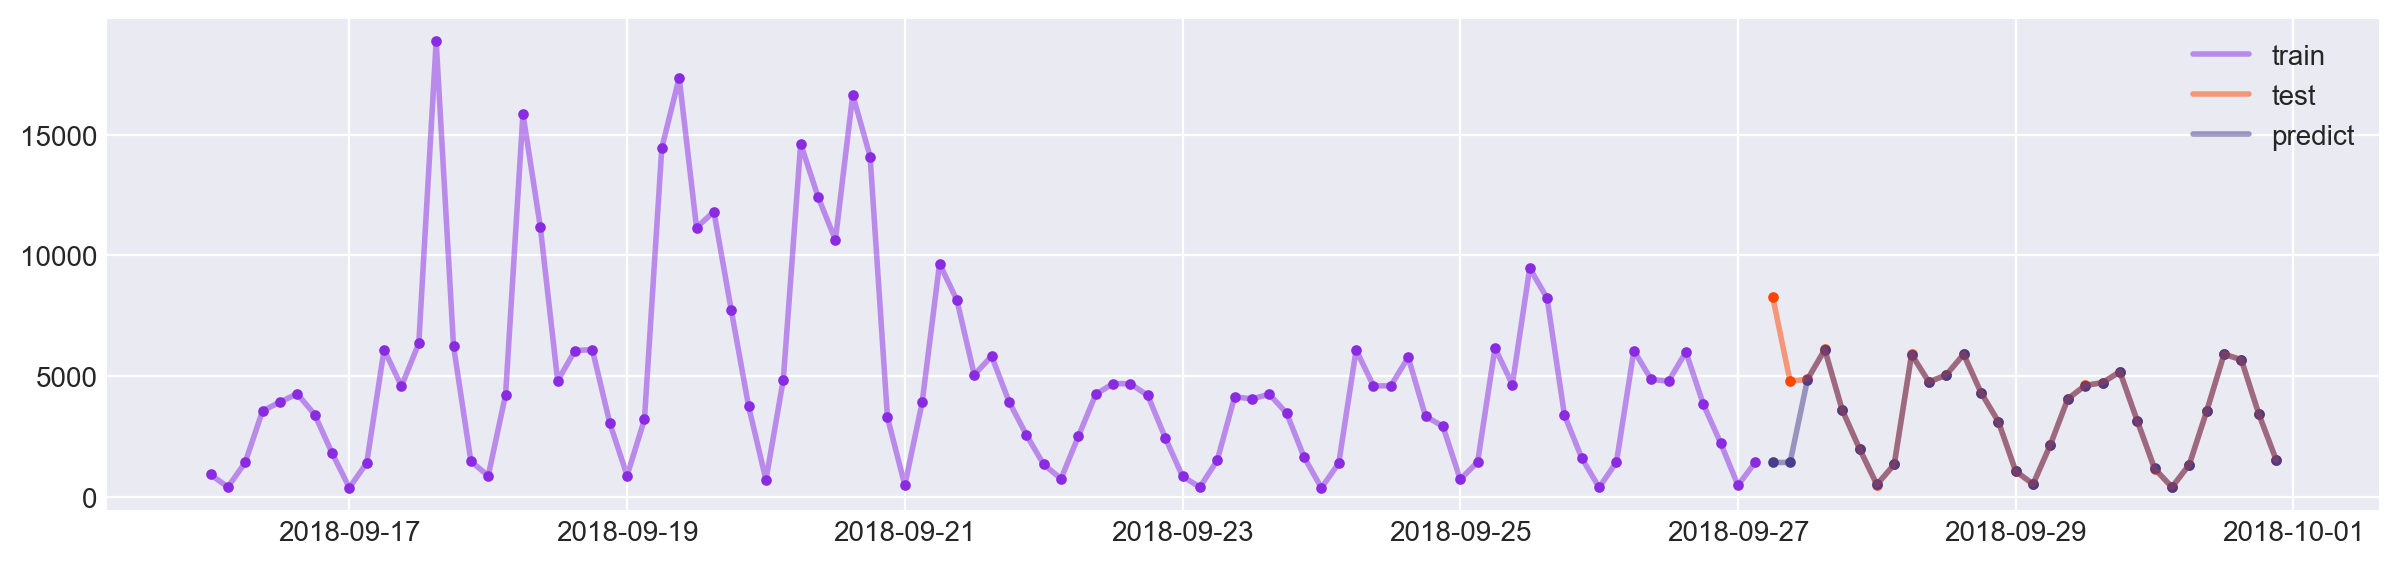

In [15]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [16]:
from sklearn.ensemble import RandomForestRegressor


model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

# best Params {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 600}

param_grid = {
    #'bootstrap': [True,False],
    # "max_depth": [7, 8, 9],
    # "min_samples_leaf": [2, 3],
    # "min_samples_split": [7, 8],
    # "n_estimators": [300, 500, 600],
    "max_depth": [9],
    "min_samples_leaf": [3],
    "min_samples_split": [7],
    "n_estimators": [600],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=600;, score=0.962 total time=  41.0s
[CV 2/3] END max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=600;, score=0.944 total time= 1.0min
[CV 3/3] END max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=600;, score=0.957 total time= 1.7min
0.9542877406004079 {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 600}


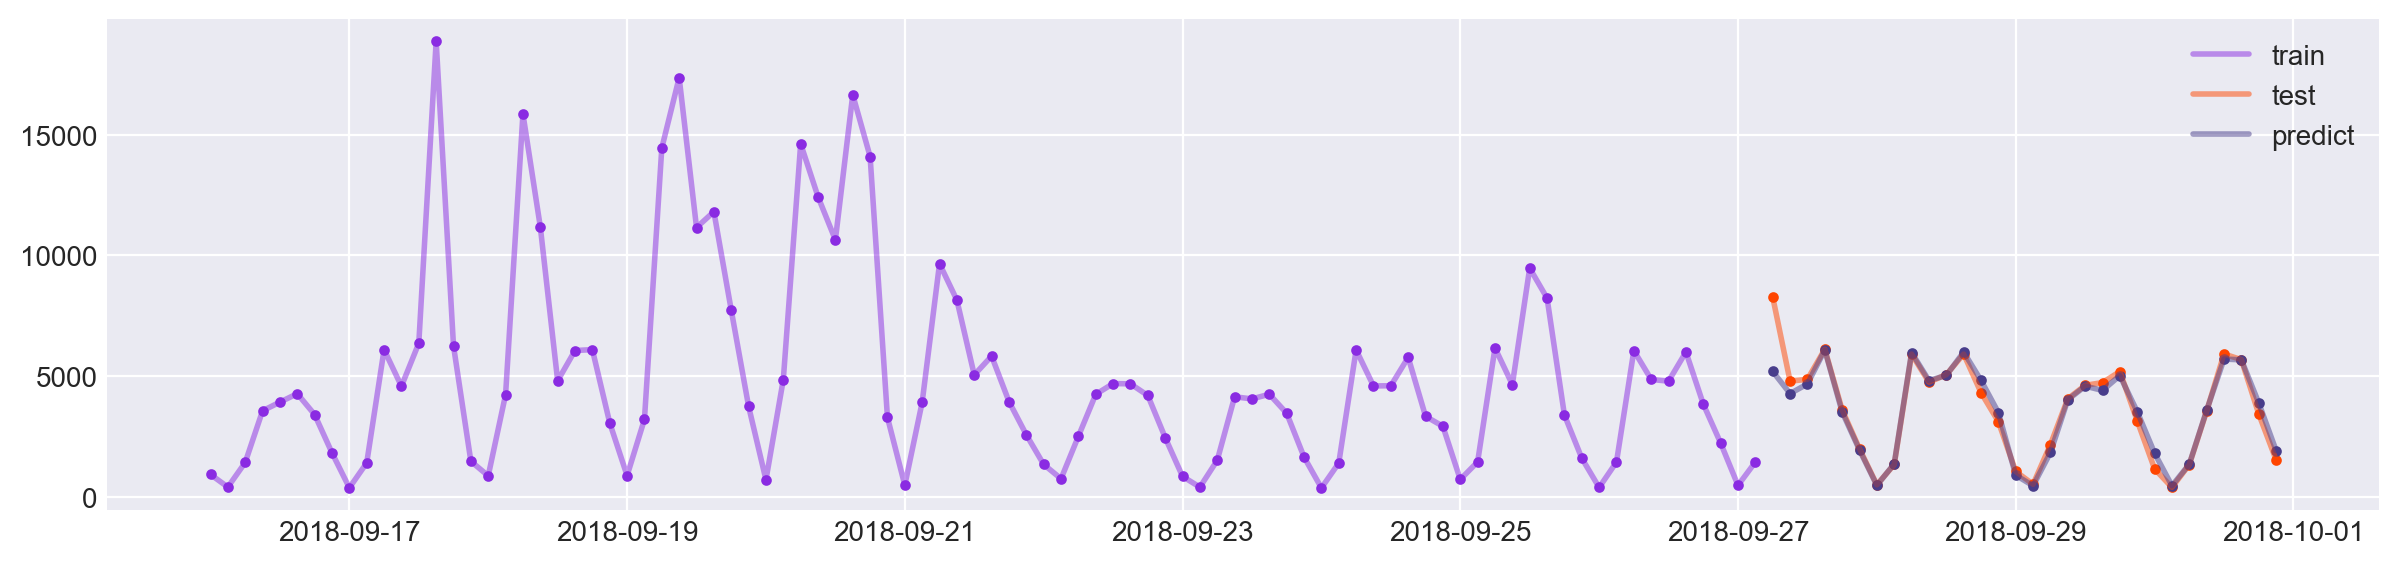

In [17]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

[0]	validation_0-mae:2958.80167	validation_1-mae:3589.58648
[1]	validation_0-mae:2929.38384	validation_1-mae:3554.80458
[2]	validation_0-mae:2900.26177	validation_1-mae:3520.06124
[3]	validation_0-mae:2871.42736	validation_1-mae:3485.72883
[4]	validation_0-mae:2842.87969	validation_1-mae:3451.57356
[5]	validation_0-mae:2814.62849	validation_1-mae:3417.65591
[6]	validation_0-mae:2786.65538	validation_1-mae:3384.46380
[7]	validation_0-mae:2758.96233	validation_1-mae:3351.22907
[8]	validation_0-mae:2731.54706	validation_1-mae:3318.47977
[9]	validation_0-mae:2704.40634	validation_1-mae:3286.16768
[10]	validation_0-mae:2677.54200	validation_1-mae:3254.21529
[11]	validation_0-mae:2650.95418	validation_1-mae:3222.24765
[12]	validation_0-mae:2624.63409	validation_1-mae:3190.96760
[13]	validation_0-mae:2598.57747	validation_1-mae:3159.79408
[14]	validation_0-mae:2572.79206	validation_1-mae:3129.09901
[15]	validation_0-mae:2547.27519	validation_1-mae:3098.72019
[16]	validation_0-mae:2522.01248	v

[135]	validation_0-mae:822.59944	validation_1-mae:1005.09376
[136]	validation_0-mae:815.42802	validation_1-mae:996.27469
[137]	validation_0-mae:808.33948	validation_1-mae:987.58042
[138]	validation_0-mae:801.36813	validation_1-mae:978.80778
[139]	validation_0-mae:794.42607	validation_1-mae:970.29554
[140]	validation_0-mae:787.60112	validation_1-mae:961.58352
[141]	validation_0-mae:780.89906	validation_1-mae:952.72387
[142]	validation_0-mae:774.18258	validation_1-mae:944.45436
[143]	validation_0-mae:767.53568	validation_1-mae:936.28023
[144]	validation_0-mae:760.92482	validation_1-mae:927.92522
[145]	validation_0-mae:754.46662	validation_1-mae:919.81397
[146]	validation_0-mae:748.17099	validation_1-mae:911.69792
[147]	validation_0-mae:741.86618	validation_1-mae:903.35161
[148]	validation_0-mae:735.58022	validation_1-mae:895.71848
[149]	validation_0-mae:729.41358	validation_1-mae:888.22479
[150]	validation_0-mae:723.21958	validation_1-mae:880.51178
[151]	validation_0-mae:717.14559	valida

[271]	validation_0-mae:308.84213	validation_1-mae:415.34458
[272]	validation_0-mae:307.09178	validation_1-mae:413.55123
[273]	validation_0-mae:305.40779	validation_1-mae:411.63983
[274]	validation_0-mae:303.81551	validation_1-mae:410.02134
[275]	validation_0-mae:302.11194	validation_1-mae:408.24028
[276]	validation_0-mae:300.42697	validation_1-mae:406.43040
[277]	validation_0-mae:298.81149	validation_1-mae:404.86426
[278]	validation_0-mae:297.15081	validation_1-mae:403.02418
[279]	validation_0-mae:295.59720	validation_1-mae:401.77012
[280]	validation_0-mae:293.97827	validation_1-mae:399.88301
[281]	validation_0-mae:292.51516	validation_1-mae:398.50727
[282]	validation_0-mae:290.96488	validation_1-mae:397.04199
[283]	validation_0-mae:289.50235	validation_1-mae:395.35300
[284]	validation_0-mae:287.99535	validation_1-mae:393.84404
[285]	validation_0-mae:286.46376	validation_1-mae:392.11584
[286]	validation_0-mae:284.99056	validation_1-mae:390.68493
[287]	validation_0-mae:283.57088	validat

[408]	validation_0-mae:182.39999	validation_1-mae:295.81918
[409]	validation_0-mae:181.94487	validation_1-mae:295.69829
[410]	validation_0-mae:181.46873	validation_1-mae:295.37213
[411]	validation_0-mae:181.00569	validation_1-mae:294.94899
[412]	validation_0-mae:180.53184	validation_1-mae:294.59388
[413]	validation_0-mae:180.06046	validation_1-mae:294.16573
[414]	validation_0-mae:179.68105	validation_1-mae:293.76780
[415]	validation_0-mae:179.25286	validation_1-mae:293.48673
[416]	validation_0-mae:178.82172	validation_1-mae:293.13871
[417]	validation_0-mae:178.50653	validation_1-mae:292.91870
[418]	validation_0-mae:178.12550	validation_1-mae:292.70656
[419]	validation_0-mae:177.64354	validation_1-mae:292.56304
[420]	validation_0-mae:177.21610	validation_1-mae:292.24623
[421]	validation_0-mae:176.85563	validation_1-mae:291.80808
[422]	validation_0-mae:176.43978	validation_1-mae:291.77454
[423]	validation_0-mae:175.96872	validation_1-mae:291.44728
[424]	validation_0-mae:175.58990	validat

[544]	validation_0-mae:145.69925	validation_1-mae:277.87270
[545]	validation_0-mae:145.50634	validation_1-mae:277.87309
[546]	validation_0-mae:145.36611	validation_1-mae:277.68114
[547]	validation_0-mae:145.15617	validation_1-mae:277.80961
[548]	validation_0-mae:145.02747	validation_1-mae:277.85364
[549]	validation_0-mae:144.82198	validation_1-mae:277.78358
[550]	validation_0-mae:144.67547	validation_1-mae:277.40827
[551]	validation_0-mae:144.53207	validation_1-mae:277.45610
[552]	validation_0-mae:144.37966	validation_1-mae:277.08539
[553]	validation_0-mae:144.24288	validation_1-mae:277.18849
[554]	validation_0-mae:144.02289	validation_1-mae:277.15362
[555]	validation_0-mae:143.79549	validation_1-mae:276.89405
[556]	validation_0-mae:143.62485	validation_1-mae:276.84549
[557]	validation_0-mae:143.39778	validation_1-mae:276.66927
[558]	validation_0-mae:143.25745	validation_1-mae:276.42262
[559]	validation_0-mae:143.12709	validation_1-mae:276.49468
[560]	validation_0-mae:142.95172	validat

[680]	validation_0-mae:126.62710	validation_1-mae:267.48533
[681]	validation_0-mae:126.54644	validation_1-mae:267.57551
[682]	validation_0-mae:126.37167	validation_1-mae:267.38610
[683]	validation_0-mae:126.29457	validation_1-mae:267.43021
[684]	validation_0-mae:126.12159	validation_1-mae:267.29818
[685]	validation_0-mae:126.04815	validation_1-mae:267.34472
[686]	validation_0-mae:125.85100	validation_1-mae:267.07870
[687]	validation_0-mae:125.77426	validation_1-mae:267.05299
[688]	validation_0-mae:125.69831	validation_1-mae:267.02643
[689]	validation_0-mae:125.57528	validation_1-mae:266.93824
[690]	validation_0-mae:125.48516	validation_1-mae:266.98885
[691]	validation_0-mae:125.40754	validation_1-mae:266.96268
[692]	validation_0-mae:125.25715	validation_1-mae:266.91572
[693]	validation_0-mae:125.18254	validation_1-mae:266.96162
[694]	validation_0-mae:125.10187	validation_1-mae:266.86925
[695]	validation_0-mae:124.94108	validation_1-mae:266.80055
[696]	validation_0-mae:124.87344	validat

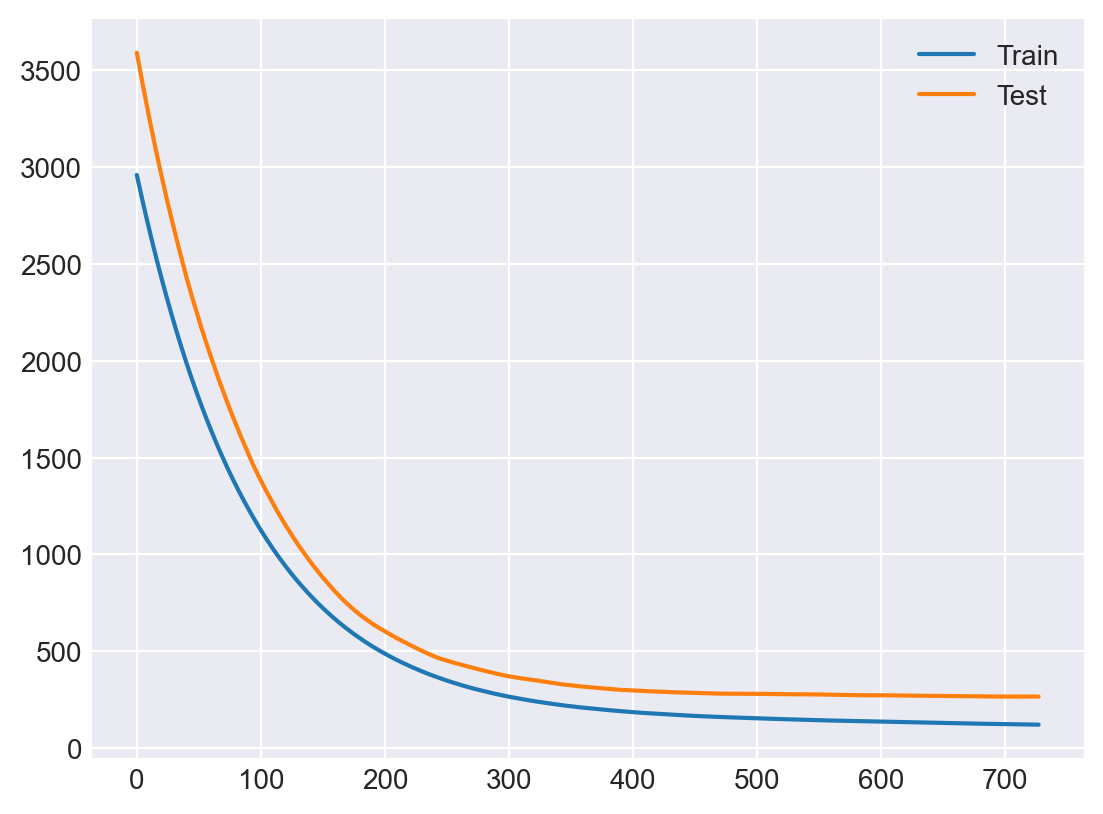

In [18]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

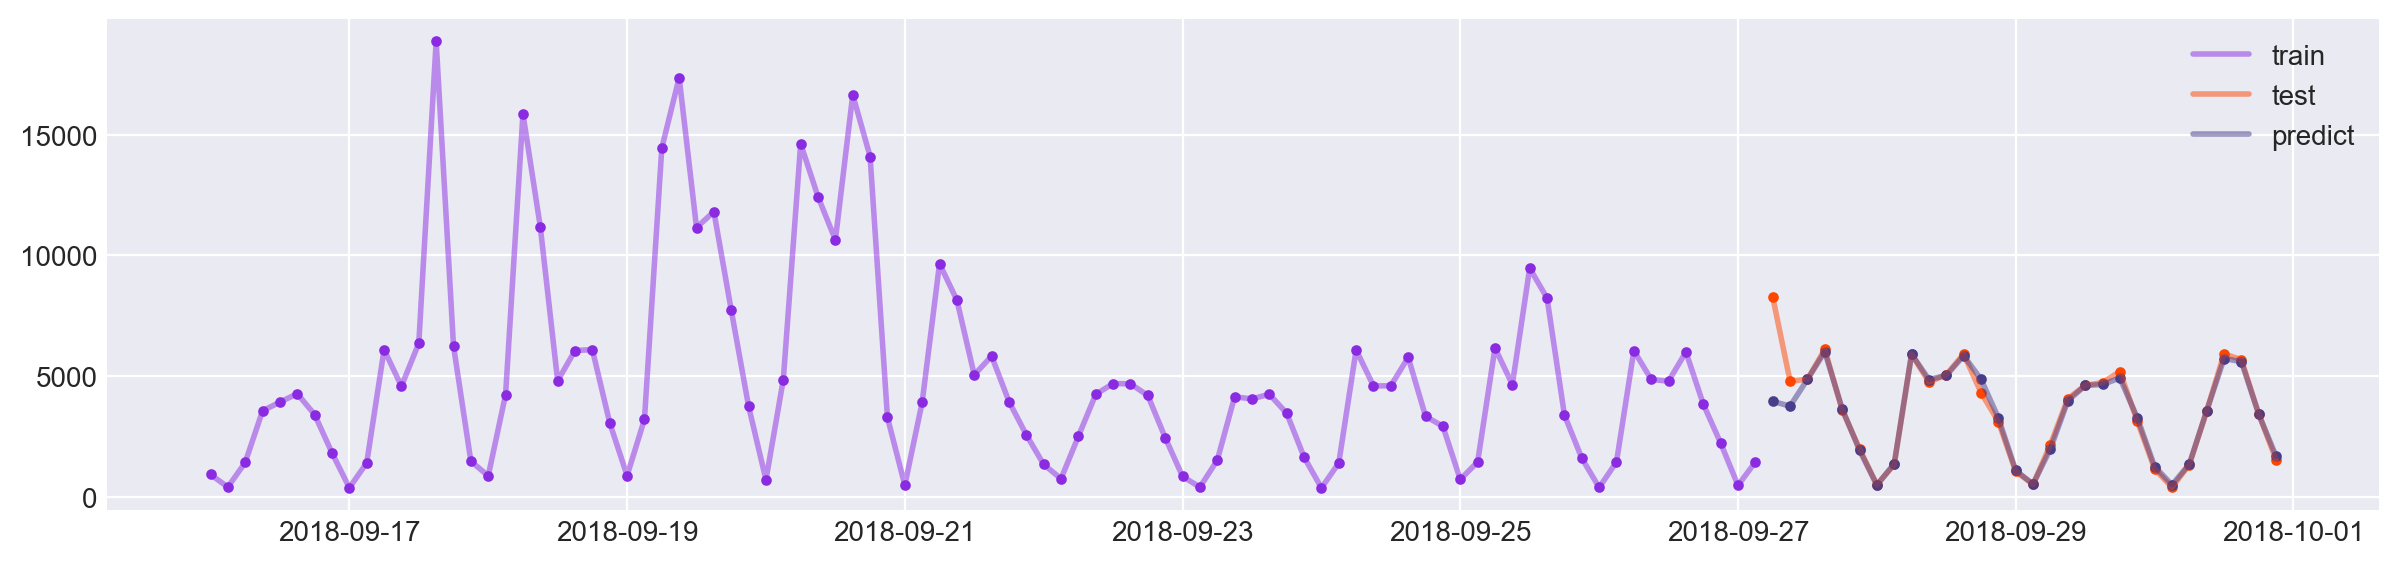

In [19]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [24]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 100000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    callbacks=[lgb.early_stopping(stopping_rounds=5000), lgb.log_evaluation()],
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

[1]	training's l1: 2019.35	training's l2: 6.53973e+06	valid_1's l1: 1661.95	valid_1's l2: 3.76598e+06
Training until validation scores don't improve for 5000 rounds
[2]	training's l1: 1835.95	training's l2: 5.4339e+06	valid_1's l1: 1517.47	valid_1's l2: 3.1701e+06
[3]	training's l1: 1672.5	training's l2: 4.53733e+06	valid_1's l1: 1378.81	valid_1's l2: 2.68301e+06
[4]	training's l1: 1525.15	training's l2: 3.80263e+06	valid_1's l1: 1265.35	valid_1's l2: 2.3173e+06
[5]	training's l1: 1394.26	training's l2: 3.198e+06	valid_1's l1: 1165.59	valid_1's l2: 2.00401e+06
[6]	training's l1: 1275.8	training's l2: 2.69892e+06	valid_1's l1: 1065.72	valid_1's l2: 1.77844e+06
[7]	training's l1: 1167.33	training's l2: 2.28141e+06	valid_1's l1: 978.242	valid_1's l2: 1.52351e+06
[8]	training's l1: 1072.11	training's l2: 1.9369e+06	valid_1's l1: 910.342	valid_1's l2: 1.3643e+06
[9]	training's l1: 986.654	training's l2: 1.65518e+06	valid_1's l1: 829.444	valid_1's l2: 1.17317e+06
[10]	training's l1: 908.431	

[89]	training's l1: 134.056	training's l2: 52718.1	valid_1's l1: 272.248	valid_1's l2: 611128
[90]	training's l1: 132.98	training's l2: 52125.7	valid_1's l1: 271.487	valid_1's l2: 610959
[91]	training's l1: 131.643	training's l2: 51384.5	valid_1's l1: 270.966	valid_1's l2: 611208
[92]	training's l1: 130.75	training's l2: 50791.6	valid_1's l1: 268.358	valid_1's l2: 609278
[93]	training's l1: 130.356	training's l2: 50187.3	valid_1's l1: 268.261	valid_1's l2: 608282
[94]	training's l1: 129.849	training's l2: 49619.6	valid_1's l1: 269.255	valid_1's l2: 616815
[95]	training's l1: 129.524	training's l2: 49158.9	valid_1's l1: 269.246	valid_1's l2: 616769
[96]	training's l1: 128.725	training's l2: 48518.7	valid_1's l1: 270.08	valid_1's l2: 617523
[97]	training's l1: 127.559	training's l2: 47983.7	valid_1's l1: 269.484	valid_1's l2: 617542
[98]	training's l1: 127.208	training's l2: 47499	valid_1's l1: 269.294	valid_1's l2: 616542
[99]	training's l1: 126.678	training's l2: 47114.5	valid_1's l1: 

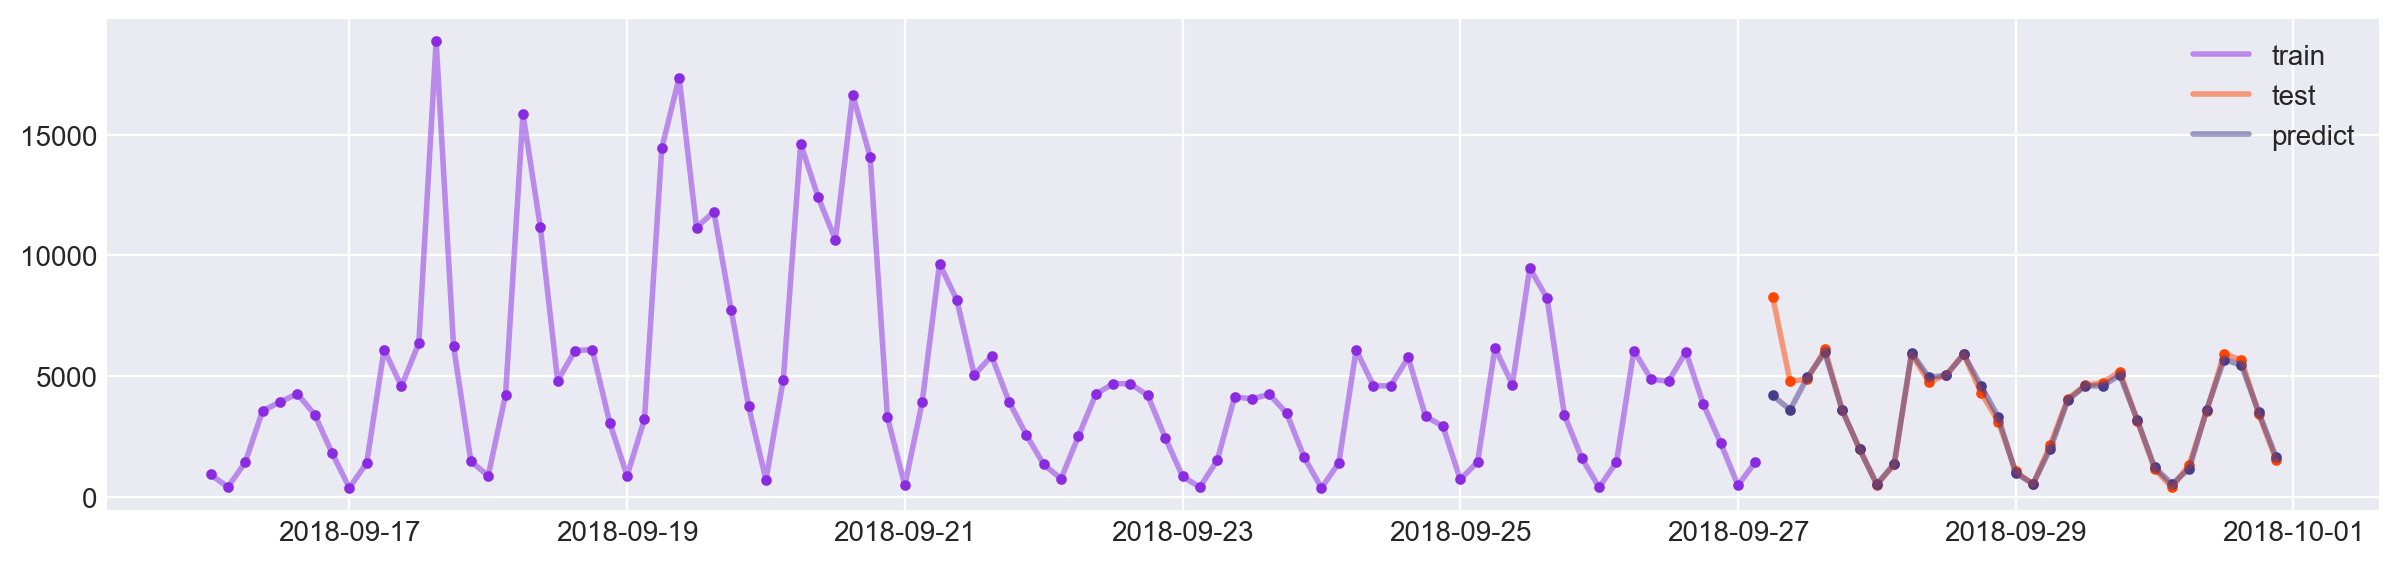

In [25]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [27]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=False
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

0:	learn: 3544.6538147	test: 4495.4469488	best: 4495.4469488 (0)	total: 35.9ms	remaining: 35.8s
1:	learn: 3257.0287332	test: 4139.7777097	best: 4139.7777097 (1)	total: 41.8ms	remaining: 20.9s
2:	learn: 3003.7907398	test: 3812.5325203	best: 3812.5325203 (2)	total: 108ms	remaining: 35.7s
3:	learn: 2785.3786305	test: 3532.0961688	best: 3532.0961688 (3)	total: 168ms	remaining: 41.8s
4:	learn: 2573.2346081	test: 3256.0180764	best: 3256.0180764 (4)	total: 197ms	remaining: 39.2s
5:	learn: 2388.6950194	test: 3024.3882308	best: 3024.3882308 (5)	total: 276ms	remaining: 45.7s
6:	learn: 2222.7947676	test: 2803.3404925	best: 2803.3404925 (6)	total: 324ms	remaining: 46s
7:	learn: 2072.8601240	test: 2606.2848888	best: 2606.2848888 (7)	total: 355ms	remaining: 44s
8:	learn: 1937.9193624	test: 2431.0411899	best: 2431.0411899 (8)	total: 416ms	remaining: 45.8s
9:	learn: 1822.7806412	test: 2283.2222263	best: 2283.2222263 (9)	total: 455ms	remaining: 45.1s
10:	learn: 1720.0791715	test: 2153.3665264	best: 215

90:	learn: 557.0842039	test: 667.2681125	best: 667.2681125 (90)	total: 2.89s	remaining: 28.8s
91:	learn: 554.3830311	test: 663.3958399	best: 663.3958399 (91)	total: 2.93s	remaining: 28.9s
92:	learn: 551.4769828	test: 662.4479419	best: 662.4479419 (92)	total: 2.97s	remaining: 28.9s
93:	learn: 549.8523604	test: 659.6372173	best: 659.6372173 (93)	total: 3.02s	remaining: 29.1s
94:	learn: 547.3290219	test: 656.4094346	best: 656.4094346 (94)	total: 3.08s	remaining: 29.4s
95:	learn: 544.3198853	test: 655.1294420	best: 655.1294420 (95)	total: 3.13s	remaining: 29.5s
96:	learn: 540.4079662	test: 652.5045767	best: 652.5045767 (96)	total: 3.17s	remaining: 29.5s
97:	learn: 537.3941773	test: 646.5166317	best: 646.5166317 (97)	total: 3.25s	remaining: 30s
98:	learn: 534.2050269	test: 642.9300202	best: 642.9300202 (98)	total: 3.3s	remaining: 30s
99:	learn: 532.5028923	test: 641.1866295	best: 641.1866295 (99)	total: 3.33s	remaining: 29.9s
100:	learn: 529.8507323	test: 636.2329666	best: 636.2329666 (100)

177:	learn: 375.9833088	test: 485.6401888	best: 485.6401888 (177)	total: 6.04s	remaining: 27.9s
178:	learn: 375.1145763	test: 485.4896404	best: 485.4896404 (178)	total: 6.04s	remaining: 27.7s
179:	learn: 373.2631493	test: 484.0700815	best: 484.0700815 (179)	total: 6.05s	remaining: 27.6s
180:	learn: 371.9987816	test: 482.1071806	best: 482.1071806 (180)	total: 6.06s	remaining: 27.4s
181:	learn: 370.6273016	test: 481.4434722	best: 481.4434722 (181)	total: 6.07s	remaining: 27.3s
182:	learn: 369.2836412	test: 480.2536002	best: 480.2536002 (182)	total: 6.1s	remaining: 27.2s
183:	learn: 368.4508010	test: 479.9175488	best: 479.9175488 (183)	total: 6.14s	remaining: 27.2s
184:	learn: 366.8793021	test: 479.1681885	best: 479.1681885 (184)	total: 6.21s	remaining: 27.3s
185:	learn: 366.0283793	test: 477.6190202	best: 477.6190202 (185)	total: 6.23s	remaining: 27.3s
186:	learn: 364.8299939	test: 477.0445513	best: 477.0445513 (186)	total: 6.27s	remaining: 27.3s
187:	learn: 363.7597426	test: 477.3663785

263:	learn: 286.0106671	test: 410.1223303	best: 410.1223303 (263)	total: 8.55s	remaining: 23.8s
264:	learn: 284.9601994	test: 409.9274792	best: 409.9274792 (264)	total: 8.6s	remaining: 23.8s
265:	learn: 283.9407308	test: 409.5661817	best: 409.5661817 (265)	total: 8.69s	remaining: 24s
266:	learn: 283.0030266	test: 408.9243206	best: 408.9243206 (266)	total: 8.73s	remaining: 24s
267:	learn: 282.1268604	test: 408.2735892	best: 408.2735892 (267)	total: 8.76s	remaining: 23.9s
268:	learn: 281.4293397	test: 407.8975415	best: 407.8975415 (268)	total: 8.85s	remaining: 24s
269:	learn: 280.6983823	test: 406.8845724	best: 406.8845724 (269)	total: 8.88s	remaining: 24s
270:	learn: 280.1827157	test: 406.0787783	best: 406.0787783 (270)	total: 8.92s	remaining: 24s
271:	learn: 279.2354442	test: 405.9070620	best: 405.9070620 (271)	total: 8.97s	remaining: 24s
272:	learn: 278.7384967	test: 406.2662514	best: 405.9070620 (271)	total: 9.04s	remaining: 24.1s
273:	learn: 277.8972421	test: 405.8312552	best: 405.8

349:	learn: 236.5544486	test: 371.5323800	best: 371.5323800 (349)	total: 12.2s	remaining: 22.7s
350:	learn: 236.2298133	test: 371.1155976	best: 371.1155976 (350)	total: 12.2s	remaining: 22.6s
351:	learn: 235.9118002	test: 370.8811750	best: 370.8811750 (351)	total: 12.2s	remaining: 22.5s
352:	learn: 235.3600834	test: 370.5867498	best: 370.5867498 (352)	total: 12.2s	remaining: 22.4s
353:	learn: 234.8225990	test: 370.0627852	best: 370.0627852 (353)	total: 12.2s	remaining: 22.3s
354:	learn: 234.2057953	test: 369.4313115	best: 369.4313115 (354)	total: 12.2s	remaining: 22.2s
355:	learn: 233.7923911	test: 368.9948097	best: 368.9948097 (355)	total: 12.3s	remaining: 22.2s
356:	learn: 233.4766495	test: 368.8646860	best: 368.8646860 (356)	total: 12.3s	remaining: 22.1s
357:	learn: 232.7719612	test: 368.6236049	best: 368.6236049 (357)	total: 12.3s	remaining: 22s
358:	learn: 232.3748384	test: 368.3525731	best: 368.3525731 (358)	total: 12.3s	remaining: 22s
359:	learn: 231.9434326	test: 368.1834949	be

436:	learn: 203.0762685	test: 348.6510622	best: 348.6510622 (436)	total: 15.2s	remaining: 19.6s
437:	learn: 202.7357253	test: 348.3292839	best: 348.3292839 (437)	total: 15.2s	remaining: 19.5s
438:	learn: 202.4190797	test: 348.1750315	best: 348.1750315 (438)	total: 15.2s	remaining: 19.5s
439:	learn: 202.2201474	test: 348.0496746	best: 348.0496746 (439)	total: 15.3s	remaining: 19.4s
440:	learn: 201.9996738	test: 348.0489132	best: 348.0489132 (440)	total: 15.3s	remaining: 19.4s
441:	learn: 201.5693554	test: 347.8671172	best: 347.8671172 (441)	total: 15.4s	remaining: 19.4s
442:	learn: 201.2154144	test: 347.8023930	best: 347.8023930 (442)	total: 15.4s	remaining: 19.4s
443:	learn: 200.9011759	test: 347.4267650	best: 347.4267650 (443)	total: 15.4s	remaining: 19.3s
444:	learn: 200.5486563	test: 347.4198441	best: 347.4198441 (444)	total: 15.5s	remaining: 19.3s
445:	learn: 200.1658137	test: 347.2988090	best: 347.2988090 (445)	total: 15.5s	remaining: 19.2s
446:	learn: 199.7692153	test: 347.173496

527:	learn: 179.8536292	test: 335.8110692	best: 335.8110692 (527)	total: 18.2s	remaining: 16.2s
528:	learn: 179.6922588	test: 335.7009153	best: 335.7009153 (528)	total: 18.2s	remaining: 16.2s
529:	learn: 179.4296607	test: 335.6454631	best: 335.6454631 (529)	total: 18.3s	remaining: 16.2s
530:	learn: 179.2940369	test: 335.1460465	best: 335.1460465 (530)	total: 18.3s	remaining: 16.2s
531:	learn: 179.0172646	test: 334.9325643	best: 334.9325643 (531)	total: 18.4s	remaining: 16.2s
532:	learn: 178.7792024	test: 334.9522479	best: 334.9325643 (531)	total: 18.5s	remaining: 16.2s
533:	learn: 178.5594461	test: 334.7703965	best: 334.7703965 (533)	total: 18.5s	remaining: 16.2s
534:	learn: 178.3305462	test: 334.6298735	best: 334.6298735 (534)	total: 18.6s	remaining: 16.1s
535:	learn: 178.1955813	test: 334.5898037	best: 334.5898037 (535)	total: 18.6s	remaining: 16.1s
536:	learn: 178.0249238	test: 334.5149889	best: 334.5149889 (536)	total: 18.6s	remaining: 16.1s
537:	learn: 177.8449454	test: 334.394254

615:	learn: 162.7434863	test: 328.1126032	best: 328.1126032 (615)	total: 21.3s	remaining: 13.3s
616:	learn: 162.5952711	test: 328.1363510	best: 328.1126032 (615)	total: 21.4s	remaining: 13.3s
617:	learn: 162.4651960	test: 328.0504515	best: 328.0504515 (617)	total: 21.4s	remaining: 13.2s
618:	learn: 162.3414726	test: 327.9285545	best: 327.9285545 (618)	total: 21.5s	remaining: 13.2s
619:	learn: 162.2030808	test: 327.8943991	best: 327.8943991 (619)	total: 21.5s	remaining: 13.2s
620:	learn: 161.9536297	test: 327.8873843	best: 327.8873843 (620)	total: 21.5s	remaining: 13.1s
621:	learn: 161.8228588	test: 328.1473457	best: 327.8873843 (620)	total: 21.6s	remaining: 13.1s
622:	learn: 161.5926646	test: 327.9360385	best: 327.8873843 (620)	total: 21.6s	remaining: 13.1s
623:	learn: 161.4013525	test: 327.9091613	best: 327.8873843 (620)	total: 21.6s	remaining: 13s
624:	learn: 161.2676630	test: 327.7327017	best: 327.7327017 (624)	total: 21.7s	remaining: 13s
625:	learn: 161.1127993	test: 327.6984947	be

703:	learn: 149.5184642	test: 323.4172431	best: 323.4172431 (703)	total: 24.7s	remaining: 10.4s
704:	learn: 149.3719795	test: 323.2897744	best: 323.2897744 (704)	total: 24.8s	remaining: 10.4s
705:	learn: 149.2716900	test: 323.2702369	best: 323.2702369 (705)	total: 24.9s	remaining: 10.4s
706:	learn: 149.1864335	test: 323.2272573	best: 323.2272573 (706)	total: 24.9s	remaining: 10.3s
707:	learn: 149.0437999	test: 323.1855138	best: 323.1855138 (707)	total: 25s	remaining: 10.3s
708:	learn: 148.8469113	test: 323.1440097	best: 323.1440097 (708)	total: 25s	remaining: 10.2s
709:	learn: 148.7388177	test: 323.0246760	best: 323.0246760 (709)	total: 25s	remaining: 10.2s
710:	learn: 148.6747187	test: 323.0191049	best: 323.0191049 (710)	total: 25s	remaining: 10.2s
711:	learn: 148.4887370	test: 322.9664876	best: 322.9664876 (711)	total: 25s	remaining: 10.1s
712:	learn: 148.3618271	test: 322.8363016	best: 322.8363016 (712)	total: 25s	remaining: 10.1s
713:	learn: 148.2652936	test: 322.8420428	best: 322.

793:	learn: 138.6405666	test: 317.6786854	best: 317.6719155 (791)	total: 28.3s	remaining: 7.33s
794:	learn: 138.5560720	test: 317.7102472	best: 317.6719155 (791)	total: 28.3s	remaining: 7.3s
795:	learn: 138.4159119	test: 317.7024684	best: 317.6719155 (791)	total: 28.4s	remaining: 7.27s
796:	learn: 138.3560495	test: 317.6171855	best: 317.6171855 (796)	total: 28.4s	remaining: 7.24s
797:	learn: 138.2042552	test: 317.5992694	best: 317.5992694 (797)	total: 28.5s	remaining: 7.2s
798:	learn: 138.0467373	test: 317.4905113	best: 317.4905113 (798)	total: 28.5s	remaining: 7.17s
799:	learn: 137.9421194	test: 317.4378279	best: 317.4378279 (799)	total: 28.5s	remaining: 7.13s
800:	learn: 137.8496598	test: 317.4577415	best: 317.4378279 (799)	total: 28.6s	remaining: 7.11s
801:	learn: 137.7595118	test: 317.4751543	best: 317.4378279 (799)	total: 28.7s	remaining: 7.08s
802:	learn: 137.6800859	test: 317.3824125	best: 317.3824125 (802)	total: 28.7s	remaining: 7.04s
803:	learn: 137.6027384	test: 317.4388082	

880:	learn: 129.7957468	test: 312.9283791	best: 312.9283791 (880)	total: 31.7s	remaining: 4.28s
881:	learn: 129.7278316	test: 313.0244846	best: 312.9283791 (880)	total: 31.7s	remaining: 4.24s
882:	learn: 129.6262067	test: 312.9673996	best: 312.9283791 (880)	total: 31.7s	remaining: 4.21s
883:	learn: 129.5160480	test: 312.9615443	best: 312.9283791 (880)	total: 31.8s	remaining: 4.17s
884:	learn: 129.4513032	test: 312.9610982	best: 312.9283791 (880)	total: 31.9s	remaining: 4.14s
885:	learn: 129.3182539	test: 312.9446661	best: 312.9283791 (880)	total: 31.9s	remaining: 4.1s
886:	learn: 129.2036118	test: 312.9248639	best: 312.9248639 (886)	total: 32s	remaining: 4.07s
887:	learn: 129.1260063	test: 312.9301802	best: 312.9248639 (886)	total: 32s	remaining: 4.04s
888:	learn: 129.0263432	test: 312.8730116	best: 312.8730116 (888)	total: 32.1s	remaining: 4s
889:	learn: 128.8762492	test: 312.8802365	best: 312.8730116 (888)	total: 32.1s	remaining: 3.96s
890:	learn: 128.7689201	test: 312.9097712	best: 

966:	learn: 122.1649781	test: 309.9638950	best: 309.9408833 (964)	total: 34.6s	remaining: 1.18s
967:	learn: 122.1053217	test: 309.8535409	best: 309.8535409 (967)	total: 34.7s	remaining: 1.15s
968:	learn: 122.0290383	test: 309.8506605	best: 309.8506605 (968)	total: 34.7s	remaining: 1.11s
969:	learn: 121.9745918	test: 309.8067158	best: 309.8067158 (969)	total: 34.8s	remaining: 1.07s
970:	learn: 121.8924352	test: 309.6753923	best: 309.6753923 (970)	total: 34.8s	remaining: 1.04s
971:	learn: 121.8439852	test: 309.6441537	best: 309.6441537 (971)	total: 34.8s	remaining: 1s
972:	learn: 121.8106182	test: 309.6005623	best: 309.6005623 (972)	total: 34.9s	remaining: 967ms
973:	learn: 121.7446505	test: 309.5555791	best: 309.5555791 (973)	total: 34.9s	remaining: 932ms
974:	learn: 121.6418556	test: 309.5433642	best: 309.5433642 (974)	total: 34.9s	remaining: 896ms
975:	learn: 121.5882932	test: 309.5445047	best: 309.5433642 (974)	total: 35s	remaining: 861ms
976:	learn: 121.5154847	test: 309.5562692	bes

61:	learn: 675.1747210	test: 809.7895575	best: 809.7895575 (61)	total: 1.89s	remaining: 28.6s
62:	learn: 669.0698062	test: 804.8842601	best: 804.8842601 (62)	total: 1.96s	remaining: 29.2s
63:	learn: 665.8999057	test: 799.5744489	best: 799.5744489 (63)	total: 2s	remaining: 29.3s
64:	learn: 661.1367879	test: 796.3051601	best: 796.3051601 (64)	total: 2.04s	remaining: 29.3s
65:	learn: 658.2217156	test: 791.5122816	best: 791.5122816 (65)	total: 2.1s	remaining: 29.7s
66:	learn: 654.9970203	test: 787.0889427	best: 787.0889427 (66)	total: 2.16s	remaining: 30s
67:	learn: 652.3205419	test: 784.1214896	best: 784.1214896 (67)	total: 2.19s	remaining: 30.1s
68:	learn: 648.1583895	test: 782.1796539	best: 782.1796539 (68)	total: 2.23s	remaining: 30s
69:	learn: 643.5314331	test: 774.7780676	best: 774.7780676 (69)	total: 2.31s	remaining: 30.7s
70:	learn: 639.9313089	test: 769.6590747	best: 769.6590747 (70)	total: 2.32s	remaining: 30.4s
71:	learn: 637.2655350	test: 764.7385287	best: 764.7385287 (71)	tota

152:	learn: 435.5511204	test: 542.7320286	best: 542.7320286 (152)	total: 4.83s	remaining: 26.8s
153:	learn: 433.9205784	test: 540.6009781	best: 540.6009781 (153)	total: 4.84s	remaining: 26.6s
154:	learn: 431.2128123	test: 538.6982455	best: 538.6982455 (154)	total: 4.85s	remaining: 26.4s
155:	learn: 428.9803084	test: 537.2529402	best: 537.2529402 (155)	total: 4.86s	remaining: 26.3s
156:	learn: 427.1186463	test: 536.2891787	best: 536.2891787 (156)	total: 4.93s	remaining: 26.5s
157:	learn: 425.6778901	test: 534.0828165	best: 534.0828165 (157)	total: 5s	remaining: 26.6s
158:	learn: 423.3680425	test: 532.9083183	best: 532.9083183 (158)	total: 5.03s	remaining: 26.6s
159:	learn: 422.2738157	test: 531.1335590	best: 531.1335590 (159)	total: 5.06s	remaining: 26.6s
160:	learn: 419.0726506	test: 529.9377708	best: 529.9377708 (160)	total: 5.07s	remaining: 26.4s
161:	learn: 418.3952733	test: 528.5851279	best: 528.5851279 (161)	total: 5.08s	remaining: 26.3s
162:	learn: 417.4974582	test: 527.9048342	b

241:	learn: 320.0148189	test: 437.5652539	best: 437.5652539 (241)	total: 8.35s	remaining: 26.2s
242:	learn: 319.3140169	test: 436.4151839	best: 436.4151839 (242)	total: 8.38s	remaining: 26.1s
243:	learn: 318.1581882	test: 436.0400594	best: 436.0400594 (243)	total: 8.41s	remaining: 26.1s
244:	learn: 317.4090003	test: 435.4748460	best: 435.4748460 (244)	total: 8.45s	remaining: 26s
245:	learn: 316.9335801	test: 434.2476566	best: 434.2476566 (245)	total: 8.47s	remaining: 26s
246:	learn: 316.2167574	test: 433.6655623	best: 433.6655623 (246)	total: 8.53s	remaining: 26s
247:	learn: 315.1832700	test: 433.0346215	best: 433.0346215 (247)	total: 8.55s	remaining: 25.9s
248:	learn: 314.0147437	test: 432.9007100	best: 432.9007100 (248)	total: 8.56s	remaining: 25.8s
249:	learn: 313.4626133	test: 433.2438435	best: 432.9007100 (248)	total: 8.56s	remaining: 25.7s
250:	learn: 312.5636058	test: 432.2069109	best: 432.2069109 (250)	total: 8.61s	remaining: 25.7s
251:	learn: 311.7407818	test: 431.8853827	best

328:	learn: 259.0573009	test: 391.1163062	best: 391.1163062 (328)	total: 11.9s	remaining: 24.2s
329:	learn: 258.4710794	test: 390.7367774	best: 390.7367774 (329)	total: 11.9s	remaining: 24.2s
330:	learn: 258.0574555	test: 390.1560622	best: 390.1560622 (330)	total: 12s	remaining: 24.2s
331:	learn: 257.7500372	test: 390.0608227	best: 390.0608227 (331)	total: 12s	remaining: 24.2s
332:	learn: 257.2344639	test: 389.5619254	best: 389.5619254 (332)	total: 12.1s	remaining: 24.1s
333:	learn: 256.9584883	test: 388.7848837	best: 388.7848837 (333)	total: 12.1s	remaining: 24.2s
334:	learn: 256.7317319	test: 388.7649518	best: 388.7649518 (334)	total: 12.1s	remaining: 24.1s
335:	learn: 255.9490589	test: 388.0882379	best: 388.0882379 (335)	total: 12.2s	remaining: 24s
336:	learn: 255.4780775	test: 387.1259135	best: 387.1259135 (336)	total: 12.2s	remaining: 23.9s
337:	learn: 254.8753179	test: 387.1169098	best: 387.1169098 (337)	total: 12.2s	remaining: 23.9s
338:	learn: 254.3718485	test: 386.4390665	best

420:	learn: 219.0673686	test: 361.8255035	best: 361.8255035 (420)	total: 15.1s	remaining: 20.8s
421:	learn: 218.7256289	test: 361.4120637	best: 361.4120637 (421)	total: 15.2s	remaining: 20.8s
422:	learn: 218.1965755	test: 361.0061932	best: 361.0061932 (422)	total: 15.2s	remaining: 20.8s
423:	learn: 217.9956087	test: 361.2382540	best: 361.0061932 (422)	total: 15.3s	remaining: 20.7s
424:	learn: 217.6885374	test: 360.7305272	best: 360.7305272 (424)	total: 15.3s	remaining: 20.8s
425:	learn: 217.4543759	test: 360.3851547	best: 360.3851547 (425)	total: 15.4s	remaining: 20.7s
426:	learn: 217.0545047	test: 360.1727407	best: 360.1727407 (426)	total: 15.4s	remaining: 20.6s
427:	learn: 216.6414869	test: 359.9790089	best: 359.9790089 (427)	total: 15.4s	remaining: 20.6s
428:	learn: 216.2649229	test: 359.4632004	best: 359.4632004 (428)	total: 15.4s	remaining: 20.6s
429:	learn: 215.8828907	test: 359.1668033	best: 359.1668033 (429)	total: 15.5s	remaining: 20.5s
430:	learn: 215.6142749	test: 359.091125

506:	learn: 192.4781383	test: 345.6334714	best: 345.6334714 (506)	total: 19s	remaining: 18.5s
507:	learn: 192.2734821	test: 345.5610311	best: 345.5610311 (507)	total: 19s	remaining: 18.4s
508:	learn: 192.0292967	test: 345.4516182	best: 345.4516182 (508)	total: 19.1s	remaining: 18.4s
509:	learn: 191.6530719	test: 345.3548282	best: 345.3548282 (509)	total: 19.1s	remaining: 18.3s
510:	learn: 191.3732260	test: 345.1288098	best: 345.1288098 (510)	total: 19.1s	remaining: 18.3s
511:	learn: 191.1014015	test: 344.9822256	best: 344.9822256 (511)	total: 19.1s	remaining: 18.2s
512:	learn: 190.8069466	test: 344.5866661	best: 344.5866661 (512)	total: 19.2s	remaining: 18.2s
513:	learn: 190.6666435	test: 344.1176247	best: 344.1176247 (513)	total: 19.3s	remaining: 18.2s
514:	learn: 190.5188482	test: 344.0969326	best: 344.0969326 (514)	total: 19.3s	remaining: 18.2s
515:	learn: 190.2642409	test: 344.1724865	best: 344.0969326 (514)	total: 19.3s	remaining: 18.1s
516:	learn: 189.9595190	test: 344.0616340	be

594:	learn: 172.8882192	test: 334.1634058	best: 333.8032992 (591)	total: 22.4s	remaining: 15.3s
595:	learn: 172.7361996	test: 334.0579081	best: 333.8032992 (591)	total: 22.4s	remaining: 15.2s
596:	learn: 172.5928636	test: 334.0225474	best: 333.8032992 (591)	total: 22.4s	remaining: 15.2s
597:	learn: 172.3936109	test: 333.8164937	best: 333.8032992 (591)	total: 22.5s	remaining: 15.1s
598:	learn: 172.2262590	test: 333.7912440	best: 333.7912440 (598)	total: 22.5s	remaining: 15.1s
599:	learn: 172.0243941	test: 333.6222967	best: 333.6222967 (599)	total: 22.6s	remaining: 15.1s
600:	learn: 171.8370285	test: 333.5382972	best: 333.5382972 (600)	total: 22.7s	remaining: 15s
601:	learn: 171.6596845	test: 333.5313403	best: 333.5313403 (601)	total: 22.7s	remaining: 15s
602:	learn: 171.5310958	test: 333.1806612	best: 333.1806612 (602)	total: 22.8s	remaining: 15s
603:	learn: 171.3616538	test: 333.0506486	best: 333.0506486 (603)	total: 22.8s	remaining: 15s
604:	learn: 171.2689984	test: 333.0020454	best: 

685:	learn: 157.6181717	test: 325.6319787	best: 325.6319787 (685)	total: 25.8s	remaining: 11.8s
686:	learn: 157.4811697	test: 325.6067208	best: 325.6067208 (686)	total: 25.8s	remaining: 11.8s
687:	learn: 157.3294341	test: 325.7538605	best: 325.6067208 (686)	total: 25.8s	remaining: 11.7s
688:	learn: 157.1474812	test: 325.6799874	best: 325.6067208 (686)	total: 25.8s	remaining: 11.7s
689:	learn: 156.9956066	test: 325.6298963	best: 325.6067208 (686)	total: 25.8s	remaining: 11.6s
690:	learn: 156.8275646	test: 325.6066517	best: 325.6066517 (690)	total: 25.9s	remaining: 11.6s
691:	learn: 156.6440724	test: 325.5663497	best: 325.5663497 (691)	total: 25.9s	remaining: 11.5s
692:	learn: 156.5374399	test: 325.4294243	best: 325.4294243 (692)	total: 26s	remaining: 11.5s
693:	learn: 156.4758109	test: 325.2602465	best: 325.2602465 (693)	total: 26s	remaining: 11.5s
694:	learn: 156.3357401	test: 325.1853427	best: 325.1853427 (694)	total: 26s	remaining: 11.4s
695:	learn: 156.1752826	test: 325.1690270	best

782:	learn: 145.0836496	test: 319.1091314	best: 319.1067099 (781)	total: 28.6s	remaining: 7.92s
783:	learn: 145.0263674	test: 319.0028364	best: 319.0028364 (783)	total: 28.6s	remaining: 7.88s
784:	learn: 144.9738608	test: 318.9051407	best: 318.9051407 (784)	total: 28.6s	remaining: 7.83s
785:	learn: 144.8327037	test: 318.7807439	best: 318.7807439 (785)	total: 28.6s	remaining: 7.79s
786:	learn: 144.7176555	test: 318.6371342	best: 318.6371342 (786)	total: 28.6s	remaining: 7.75s
787:	learn: 144.5815299	test: 318.4857241	best: 318.4857241 (787)	total: 28.7s	remaining: 7.71s
788:	learn: 144.4699079	test: 318.6128069	best: 318.4857241 (787)	total: 28.7s	remaining: 7.67s
789:	learn: 144.3780695	test: 318.5200267	best: 318.4857241 (787)	total: 28.7s	remaining: 7.64s
790:	learn: 144.2120957	test: 318.4243810	best: 318.4243810 (790)	total: 28.8s	remaining: 7.61s
791:	learn: 144.0947569	test: 318.3696362	best: 318.3696362 (791)	total: 28.9s	remaining: 7.58s
792:	learn: 144.0092909	test: 318.417999

870:	learn: 136.0149033	test: 314.8162264	best: 314.8162264 (870)	total: 31.2s	remaining: 4.63s
871:	learn: 135.9109062	test: 314.7603093	best: 314.7603093 (871)	total: 31.3s	remaining: 4.59s
872:	learn: 135.8304256	test: 314.7575321	best: 314.7575321 (872)	total: 31.3s	remaining: 4.55s
873:	learn: 135.7667665	test: 314.6856406	best: 314.6856406 (873)	total: 31.4s	remaining: 4.52s
874:	learn: 135.6658956	test: 314.7371550	best: 314.6856406 (873)	total: 31.4s	remaining: 4.48s
875:	learn: 135.5421714	test: 314.5921911	best: 314.5921911 (875)	total: 31.4s	remaining: 4.45s
876:	learn: 135.4178460	test: 314.5868511	best: 314.5868511 (876)	total: 31.5s	remaining: 4.41s
877:	learn: 135.3028611	test: 314.5608671	best: 314.5608671 (877)	total: 31.5s	remaining: 4.38s
878:	learn: 135.2467857	test: 314.5075714	best: 314.5075714 (878)	total: 31.6s	remaining: 4.35s
879:	learn: 135.0946675	test: 314.3142906	best: 314.3142906 (879)	total: 31.6s	remaining: 4.31s
880:	learn: 134.9519786	test: 314.279218

964:	learn: 127.6469771	test: 310.2155751	best: 310.2155751 (964)	total: 34.6s	remaining: 1.25s
965:	learn: 127.5885744	test: 310.3069578	best: 310.2155751 (964)	total: 34.6s	remaining: 1.22s
966:	learn: 127.4519713	test: 310.2602692	best: 310.2155751 (964)	total: 34.6s	remaining: 1.18s
967:	learn: 127.3718076	test: 310.1455277	best: 310.1455277 (967)	total: 34.6s	remaining: 1.15s
968:	learn: 127.3044413	test: 310.2430456	best: 310.1455277 (967)	total: 34.7s	remaining: 1.11s
969:	learn: 127.2266098	test: 310.2559775	best: 310.1455277 (967)	total: 34.8s	remaining: 1.07s
970:	learn: 127.1528241	test: 310.1678353	best: 310.1455277 (967)	total: 34.8s	remaining: 1.04s
971:	learn: 127.0595523	test: 310.1234801	best: 310.1234801 (971)	total: 34.9s	remaining: 1s
972:	learn: 126.9531439	test: 310.1133135	best: 310.1133135 (972)	total: 34.9s	remaining: 969ms
973:	learn: 126.8591346	test: 310.0822369	best: 310.0822369 (973)	total: 35s	remaining: 933ms
974:	learn: 126.7987859	test: 310.0204130	bes

51:	learn: 731.2300354	test: 776.6311352	best: 776.6311352 (51)	total: 2.25s	remaining: 41.1s
52:	learn: 727.0851162	test: 774.7762528	best: 774.7762528 (52)	total: 2.32s	remaining: 41.4s
53:	learn: 721.1680883	test: 767.9447403	best: 767.9447403 (53)	total: 2.34s	remaining: 41s
54:	learn: 714.4739090	test: 762.1032843	best: 762.1032843 (54)	total: 2.35s	remaining: 40.4s
55:	learn: 708.9699241	test: 758.0191747	best: 758.0191747 (55)	total: 2.36s	remaining: 39.8s
56:	learn: 703.1187248	test: 751.8275143	best: 751.8275143 (56)	total: 2.4s	remaining: 39.7s
57:	learn: 699.7903929	test: 750.2489228	best: 750.2489228 (57)	total: 2.47s	remaining: 40.2s
58:	learn: 693.7265530	test: 746.2501006	best: 746.2501006 (58)	total: 2.49s	remaining: 39.8s
59:	learn: 687.9209699	test: 739.9025043	best: 739.9025043 (59)	total: 2.51s	remaining: 39.3s
60:	learn: 682.1847185	test: 734.3814292	best: 734.3814292 (60)	total: 2.52s	remaining: 38.7s
61:	learn: 677.5378661	test: 730.2932945	best: 730.2932945 (61)

138:	learn: 455.8789957	test: 534.0397324	best: 534.0397324 (138)	total: 4.65s	remaining: 28.8s
139:	learn: 453.9090043	test: 532.7183146	best: 532.7183146 (139)	total: 4.66s	remaining: 28.6s
140:	learn: 452.9183990	test: 532.7745333	best: 532.7183146 (139)	total: 4.66s	remaining: 28.4s
141:	learn: 450.0375340	test: 528.8067940	best: 528.8067940 (141)	total: 4.67s	remaining: 28.2s
142:	learn: 449.0240023	test: 528.2496100	best: 528.2496100 (142)	total: 4.67s	remaining: 28s
143:	learn: 446.9429996	test: 526.6270616	best: 526.6270616 (143)	total: 4.67s	remaining: 27.8s
144:	learn: 444.9713913	test: 525.1000608	best: 525.1000608 (144)	total: 4.68s	remaining: 27.6s
145:	learn: 442.2911275	test: 522.2226997	best: 522.2226997 (145)	total: 4.69s	remaining: 27.5s
146:	learn: 440.5363503	test: 520.9934659	best: 520.9934659 (146)	total: 4.73s	remaining: 27.4s
147:	learn: 439.0785322	test: 520.0009104	best: 520.0009104 (147)	total: 4.77s	remaining: 27.4s
148:	learn: 436.7089859	test: 517.6298369	

224:	learn: 335.8176122	test: 437.1556234	best: 437.1556234 (224)	total: 7.8s	remaining: 26.9s
225:	learn: 334.1980600	test: 435.8578029	best: 435.8578029 (225)	total: 7.88s	remaining: 27s
226:	learn: 333.0494172	test: 434.9900381	best: 434.9900381 (226)	total: 7.94s	remaining: 27s
227:	learn: 331.4622391	test: 433.1347666	best: 433.1347666 (227)	total: 7.97s	remaining: 27s
228:	learn: 330.6119028	test: 432.5380986	best: 432.5380986 (228)	total: 8.05s	remaining: 27.1s
229:	learn: 330.1744659	test: 432.4352488	best: 432.4352488 (229)	total: 8.09s	remaining: 27.1s
230:	learn: 329.1566188	test: 431.4394961	best: 431.4394961 (230)	total: 8.13s	remaining: 27.1s
231:	learn: 328.5396709	test: 431.2558082	best: 431.2558082 (231)	total: 8.21s	remaining: 27.2s
232:	learn: 327.6623856	test: 430.7801994	best: 430.7801994 (232)	total: 8.25s	remaining: 27.2s
233:	learn: 326.3867702	test: 429.6492827	best: 429.6492827 (233)	total: 8.26s	remaining: 27s
234:	learn: 325.0902540	test: 427.8706570	best: 4

312:	learn: 266.8270645	test: 379.1151586	best: 379.1151586 (312)	total: 11.2s	remaining: 24.6s
313:	learn: 266.4230346	test: 378.7564480	best: 378.7564480 (313)	total: 11.2s	remaining: 24.5s
314:	learn: 265.2587506	test: 377.6867283	best: 377.6867283 (314)	total: 11.2s	remaining: 24.4s
315:	learn: 264.5464308	test: 376.7795404	best: 376.7795404 (315)	total: 11.2s	remaining: 24.3s
316:	learn: 263.9137398	test: 376.3692338	best: 376.3692338 (316)	total: 11.3s	remaining: 24.3s
317:	learn: 263.3621197	test: 375.9890309	best: 375.9890309 (317)	total: 11.4s	remaining: 24.4s
318:	learn: 262.9792957	test: 375.7940075	best: 375.7940075 (318)	total: 11.4s	remaining: 24.3s
319:	learn: 262.5314849	test: 375.3976368	best: 375.3976368 (319)	total: 11.5s	remaining: 24.4s
320:	learn: 261.8740174	test: 374.8621635	best: 374.8621635 (320)	total: 11.5s	remaining: 24.3s
321:	learn: 261.2965450	test: 374.5659111	best: 374.5659111 (321)	total: 11.5s	remaining: 24.2s
322:	learn: 260.8561905	test: 374.425051

402:	learn: 225.3758305	test: 344.4024116	best: 344.4024116 (402)	total: 14.4s	remaining: 21.4s
403:	learn: 225.1630734	test: 344.1366368	best: 344.1366368 (403)	total: 14.4s	remaining: 21.3s
404:	learn: 224.7873944	test: 343.8443683	best: 343.8443683 (404)	total: 14.4s	remaining: 21.2s
405:	learn: 224.4364895	test: 344.1073942	best: 343.8443683 (404)	total: 14.5s	remaining: 21.2s
406:	learn: 223.8836044	test: 343.4891187	best: 343.4891187 (406)	total: 14.5s	remaining: 21.1s
407:	learn: 223.4643810	test: 343.3396220	best: 343.3396220 (407)	total: 14.5s	remaining: 21.1s
408:	learn: 223.2729731	test: 343.2733950	best: 343.2733950 (408)	total: 14.6s	remaining: 21s
409:	learn: 223.0200585	test: 342.9617674	best: 342.9617674 (409)	total: 14.6s	remaining: 21s
410:	learn: 222.5550553	test: 342.5579058	best: 342.5579058 (410)	total: 14.6s	remaining: 21s
411:	learn: 222.1186536	test: 342.2943363	best: 342.2943363 (411)	total: 14.7s	remaining: 20.9s
412:	learn: 221.7435444	test: 342.2436425	best

494:	learn: 196.3365565	test: 321.3958651	best: 321.3958651 (494)	total: 17.8s	remaining: 18.1s
495:	learn: 196.1367670	test: 320.9552818	best: 320.9552818 (495)	total: 17.8s	remaining: 18.1s
496:	learn: 195.9567829	test: 321.1379958	best: 320.9552818 (495)	total: 17.8s	remaining: 18s
497:	learn: 195.6605326	test: 320.9837372	best: 320.9552818 (495)	total: 17.8s	remaining: 17.9s
498:	learn: 195.4113671	test: 320.7746900	best: 320.7746900 (498)	total: 17.8s	remaining: 17.9s
499:	learn: 195.2167484	test: 320.7064881	best: 320.7064881 (499)	total: 17.9s	remaining: 17.9s
500:	learn: 195.0069713	test: 320.5951906	best: 320.5951906 (500)	total: 17.9s	remaining: 17.9s
501:	learn: 194.6540798	test: 320.0417699	best: 320.0417699 (501)	total: 18s	remaining: 17.9s
502:	learn: 194.4608779	test: 319.9579302	best: 319.9579302 (502)	total: 18.1s	remaining: 17.9s
503:	learn: 194.2487014	test: 319.7472939	best: 319.7472939 (503)	total: 18.1s	remaining: 17.8s
504:	learn: 193.9988816	test: 319.5372830	be

587:	learn: 175.7123596	test: 306.3116090	best: 306.3116090 (587)	total: 20.5s	remaining: 14.3s
588:	learn: 175.5319634	test: 306.2339763	best: 306.2339763 (588)	total: 20.5s	remaining: 14.3s
589:	learn: 175.3724336	test: 305.8842207	best: 305.8842207 (589)	total: 20.5s	remaining: 14.2s
590:	learn: 175.1748130	test: 305.7574683	best: 305.7574683 (590)	total: 20.5s	remaining: 14.2s
591:	learn: 175.0053862	test: 305.7067602	best: 305.7067602 (591)	total: 20.5s	remaining: 14.2s
592:	learn: 174.8325559	test: 305.5923124	best: 305.5923124 (592)	total: 20.6s	remaining: 14.2s
593:	learn: 174.6075065	test: 305.4424535	best: 305.4424535 (593)	total: 20.7s	remaining: 14.1s
594:	learn: 174.4272842	test: 305.4406064	best: 305.4406064 (594)	total: 20.7s	remaining: 14.1s
595:	learn: 174.1703297	test: 305.1824780	best: 305.1824780 (595)	total: 20.8s	remaining: 14.1s
596:	learn: 173.9998954	test: 305.0526093	best: 305.0526093 (596)	total: 20.8s	remaining: 14.1s
597:	learn: 173.7442841	test: 304.867675

677:	learn: 160.8525310	test: 296.8269752	best: 296.8269752 (677)	total: 24s	remaining: 11.4s
678:	learn: 160.7546455	test: 296.8170283	best: 296.8170283 (678)	total: 24.1s	remaining: 11.4s
679:	learn: 160.5839419	test: 296.5876571	best: 296.5876571 (679)	total: 24.1s	remaining: 11.4s
680:	learn: 160.4759003	test: 296.3582601	best: 296.3582601 (680)	total: 24.2s	remaining: 11.3s
681:	learn: 160.3190750	test: 296.2907905	best: 296.2907905 (681)	total: 24.2s	remaining: 11.3s
682:	learn: 160.1183715	test: 295.7805180	best: 295.7805180 (682)	total: 24.3s	remaining: 11.3s
683:	learn: 159.9983070	test: 295.8602493	best: 295.7805180 (682)	total: 24.3s	remaining: 11.2s
684:	learn: 159.8631274	test: 295.8474332	best: 295.7805180 (682)	total: 24.3s	remaining: 11.2s
685:	learn: 159.6898049	test: 295.7227478	best: 295.7227478 (685)	total: 24.3s	remaining: 11.1s
686:	learn: 159.5261446	test: 295.6234879	best: 295.6234879 (686)	total: 24.3s	remaining: 11.1s
687:	learn: 159.4005271	test: 295.5762906	

766:	learn: 148.6798081	test: 288.6023919	best: 288.6023919 (766)	total: 27.5s	remaining: 8.35s
767:	learn: 148.5367981	test: 288.4981276	best: 288.4981276 (767)	total: 27.5s	remaining: 8.3s
768:	learn: 148.4456265	test: 288.4403531	best: 288.4403531 (768)	total: 27.5s	remaining: 8.26s
769:	learn: 148.3358014	test: 288.3722085	best: 288.3722085 (769)	total: 27.5s	remaining: 8.22s
770:	learn: 148.2579388	test: 288.3266610	best: 288.3266610 (770)	total: 27.5s	remaining: 8.17s
771:	learn: 148.1425243	test: 288.3235681	best: 288.3235681 (771)	total: 27.5s	remaining: 8.13s
772:	learn: 148.0110130	test: 288.1798371	best: 288.1798371 (772)	total: 27.6s	remaining: 8.1s
773:	learn: 147.9176095	test: 288.1983980	best: 288.1798371 (772)	total: 27.6s	remaining: 8.07s
774:	learn: 147.7115130	test: 288.0398629	best: 288.0398629 (774)	total: 27.7s	remaining: 8.04s
775:	learn: 147.5826141	test: 288.1603612	best: 288.0398629 (774)	total: 27.7s	remaining: 8s
776:	learn: 147.4267994	test: 288.0649893	bes

855:	learn: 138.8939595	test: 282.5864546	best: 282.5694410 (851)	total: 31s	remaining: 5.21s
856:	learn: 138.7841521	test: 282.5193390	best: 282.5193390 (856)	total: 31s	remaining: 5.18s
857:	learn: 138.6844759	test: 282.4394579	best: 282.4394579 (857)	total: 31.1s	remaining: 5.14s
858:	learn: 138.6031280	test: 282.3678626	best: 282.3678626 (858)	total: 31.1s	remaining: 5.11s
859:	learn: 138.5297250	test: 282.4599936	best: 282.3678626 (858)	total: 31.2s	remaining: 5.08s
860:	learn: 138.4234761	test: 282.4957644	best: 282.3678626 (858)	total: 31.2s	remaining: 5.04s
861:	learn: 138.2932344	test: 282.2995954	best: 282.2995954 (861)	total: 31.3s	remaining: 5.01s
862:	learn: 138.2556201	test: 282.2700775	best: 282.2700775 (862)	total: 31.3s	remaining: 4.97s
863:	learn: 138.1591450	test: 282.1867932	best: 282.1867932 (863)	total: 31.4s	remaining: 4.94s
864:	learn: 138.0672226	test: 282.1737495	best: 282.1737495 (864)	total: 31.4s	remaining: 4.91s
865:	learn: 137.9671266	test: 282.1044397	be

941:	learn: 130.7749366	test: 278.2503454	best: 278.2503454 (941)	total: 34.6s	remaining: 2.13s
942:	learn: 130.6799968	test: 278.1796840	best: 278.1796840 (942)	total: 34.6s	remaining: 2.09s
943:	learn: 130.6063312	test: 278.1296041	best: 278.1296041 (943)	total: 34.6s	remaining: 2.05s
944:	learn: 130.5424090	test: 278.2035468	best: 278.1296041 (943)	total: 34.6s	remaining: 2.01s
945:	learn: 130.4106423	test: 278.0369607	best: 278.0369607 (945)	total: 34.7s	remaining: 1.98s
946:	learn: 130.3610964	test: 278.0275987	best: 278.0275987 (946)	total: 34.7s	remaining: 1.94s
947:	learn: 130.2982021	test: 277.9444127	best: 277.9444127 (947)	total: 34.8s	remaining: 1.91s
948:	learn: 130.2125928	test: 277.9123946	best: 277.9123946 (948)	total: 34.8s	remaining: 1.87s
949:	learn: 130.1530252	test: 277.7748737	best: 277.7748737 (949)	total: 34.8s	remaining: 1.83s
950:	learn: 130.0778468	test: 277.8109911	best: 277.7748737 (949)	total: 34.8s	remaining: 1.79s
951:	learn: 129.9422224	test: 277.790039

26:	learn: 1036.3152189	test: 874.9085911	best: 874.9085911 (26)	total: 849ms	remaining: 30.6s
27:	learn: 1020.4191539	test: 858.3693860	best: 858.3693860 (27)	total: 890ms	remaining: 30.9s
28:	learn: 998.1009021	test: 847.2256349	best: 847.2256349 (28)	total: 953ms	remaining: 31.9s
29:	learn: 981.0655526	test: 840.5681504	best: 840.5681504 (29)	total: 1.01s	remaining: 32.5s
30:	learn: 962.4187651	test: 819.2226133	best: 819.2226133 (30)	total: 1.04s	remaining: 32.6s
31:	learn: 945.9816095	test: 809.1267545	best: 809.1267545 (31)	total: 1.11s	remaining: 33.5s
32:	learn: 931.2765037	test: 804.1219205	best: 804.1219205 (32)	total: 1.17s	remaining: 34.3s
33:	learn: 918.7919620	test: 788.7585173	best: 788.7585173 (33)	total: 1.2s	remaining: 34.1s
34:	learn: 902.4374960	test: 779.6914938	best: 779.6914938 (34)	total: 1.28s	remaining: 35.2s
35:	learn: 891.6139257	test: 776.1666516	best: 776.1666516 (35)	total: 1.32s	remaining: 35.5s
36:	learn: 880.0310963	test: 762.2152325	best: 762.2152325 

126:	learn: 489.2046113	test: 485.5708446	best: 485.5708446 (126)	total: 4.88s	remaining: 33.6s
127:	learn: 486.9775140	test: 483.7543787	best: 483.7543787 (127)	total: 4.94s	remaining: 33.6s
128:	learn: 482.9975774	test: 479.0741048	best: 479.0741048 (128)	total: 5.04s	remaining: 34s
129:	learn: 481.4141162	test: 478.3071894	best: 478.3071894 (129)	total: 5.08s	remaining: 34s
130:	learn: 479.2928396	test: 477.1671329	best: 477.1671329 (130)	total: 5.09s	remaining: 33.8s
131:	learn: 477.4510909	test: 475.1066046	best: 475.1066046 (131)	total: 5.1s	remaining: 33.5s
132:	learn: 475.7330444	test: 474.3625072	best: 474.3625072 (132)	total: 5.11s	remaining: 33.3s
133:	learn: 474.0914087	test: 472.5502600	best: 472.5502600 (133)	total: 5.12s	remaining: 33.1s
134:	learn: 472.3540426	test: 471.6134762	best: 471.6134762 (134)	total: 5.2s	remaining: 33.3s
135:	learn: 470.7953407	test: 470.9122499	best: 470.9122499 (135)	total: 5.25s	remaining: 33.3s
136:	learn: 467.1056230	test: 468.3799691	best

221:	learn: 346.9490961	test: 378.0865377	best: 378.0865377 (221)	total: 8.68s	remaining: 30.4s
222:	learn: 346.3895944	test: 378.2427538	best: 378.0865377 (221)	total: 8.72s	remaining: 30.4s
223:	learn: 344.8854030	test: 376.3121264	best: 376.3121264 (223)	total: 8.77s	remaining: 30.4s
224:	learn: 343.2357709	test: 374.9798927	best: 374.9798927 (224)	total: 8.84s	remaining: 30.5s
225:	learn: 342.6322561	test: 374.3323413	best: 374.3323413 (225)	total: 8.88s	remaining: 30.4s
226:	learn: 342.0756519	test: 374.4179653	best: 374.3323413 (225)	total: 8.89s	remaining: 30.3s
227:	learn: 341.1006710	test: 374.1274348	best: 374.1274348 (227)	total: 8.9s	remaining: 30.1s
228:	learn: 340.5473258	test: 374.2327878	best: 374.1274348 (227)	total: 8.92s	remaining: 30s
229:	learn: 339.8159765	test: 373.6766213	best: 373.6766213 (229)	total: 8.99s	remaining: 30.1s
230:	learn: 338.5168792	test: 372.7675084	best: 372.7675084 (230)	total: 9.03s	remaining: 30.1s
231:	learn: 338.0128372	test: 372.8687917	b

313:	learn: 278.9611757	test: 323.5098775	best: 323.5098775 (313)	total: 12.2s	remaining: 26.7s
314:	learn: 278.1470994	test: 322.8631591	best: 322.8631591 (314)	total: 12.2s	remaining: 26.5s
315:	learn: 277.7306483	test: 322.8676113	best: 322.8631591 (314)	total: 12.2s	remaining: 26.4s
316:	learn: 277.4521412	test: 322.8815580	best: 322.8631591 (314)	total: 12.2s	remaining: 26.3s
317:	learn: 276.5965975	test: 321.6987048	best: 321.6987048 (317)	total: 12.3s	remaining: 26.3s
318:	learn: 275.7607410	test: 320.7254272	best: 320.7254272 (318)	total: 12.3s	remaining: 26.3s
319:	learn: 275.2815523	test: 320.6011704	best: 320.6011704 (319)	total: 12.4s	remaining: 26.3s
320:	learn: 274.5008699	test: 319.8872344	best: 319.8872344 (320)	total: 12.4s	remaining: 26.2s
321:	learn: 274.0087024	test: 319.3223473	best: 319.3223473 (321)	total: 12.5s	remaining: 26.3s
322:	learn: 273.2322930	test: 318.8298114	best: 318.8298114 (322)	total: 12.5s	remaining: 26.3s
323:	learn: 272.8000647	test: 318.626726

409:	learn: 234.2396581	test: 285.1320558	best: 285.1320558 (409)	total: 14.8s	remaining: 21.4s
410:	learn: 233.8673807	test: 284.5389124	best: 284.5389124 (410)	total: 14.9s	remaining: 21.3s
411:	learn: 233.4490480	test: 284.4577244	best: 284.4577244 (411)	total: 14.9s	remaining: 21.2s
412:	learn: 233.0011211	test: 284.2350592	best: 284.2350592 (412)	total: 14.9s	remaining: 21.2s
413:	learn: 232.7292447	test: 283.5683714	best: 283.5683714 (413)	total: 14.9s	remaining: 21.1s
414:	learn: 232.4048800	test: 283.6067066	best: 283.5683714 (413)	total: 14.9s	remaining: 21s
415:	learn: 231.9540448	test: 282.9740987	best: 282.9740987 (415)	total: 15s	remaining: 21s
416:	learn: 231.6860565	test: 283.2533045	best: 282.9740987 (415)	total: 15s	remaining: 21s
417:	learn: 231.2496216	test: 282.9637088	best: 282.9637088 (417)	total: 15.1s	remaining: 21s
418:	learn: 230.7218284	test: 281.8533743	best: 281.8533743 (418)	total: 15.1s	remaining: 20.9s
419:	learn: 230.1741896	test: 280.9529162	best: 280.

495:	learn: 207.8950154	test: 263.3791191	best: 263.3791191 (495)	total: 17.6s	remaining: 17.9s
496:	learn: 207.6145240	test: 263.2516405	best: 263.2516405 (496)	total: 17.6s	remaining: 17.9s
497:	learn: 207.4584285	test: 263.2745589	best: 263.2516405 (496)	total: 17.7s	remaining: 17.8s
498:	learn: 207.3710835	test: 263.3038889	best: 263.2516405 (496)	total: 17.7s	remaining: 17.8s
499:	learn: 207.0911206	test: 262.8129947	best: 262.8129947 (499)	total: 17.8s	remaining: 17.8s
500:	learn: 206.7164656	test: 262.3033841	best: 262.3033841 (500)	total: 17.8s	remaining: 17.8s
501:	learn: 206.2848366	test: 262.1135125	best: 262.1135125 (501)	total: 17.9s	remaining: 17.7s
502:	learn: 206.0667969	test: 261.7155995	best: 261.7155995 (502)	total: 17.9s	remaining: 17.7s
503:	learn: 205.8387014	test: 261.6010320	best: 261.6010320 (503)	total: 18s	remaining: 17.7s
504:	learn: 205.4918146	test: 261.4983367	best: 261.4983367 (504)	total: 18.1s	remaining: 17.7s
505:	learn: 205.0605307	test: 261.2102137	

583:	learn: 188.3589270	test: 247.5345688	best: 247.5345688 (583)	total: 20.5s	remaining: 14.6s
584:	learn: 188.1301477	test: 247.3579573	best: 247.3579573 (584)	total: 20.6s	remaining: 14.6s
585:	learn: 187.9518639	test: 247.3778099	best: 247.3579573 (584)	total: 20.6s	remaining: 14.5s
586:	learn: 187.7830444	test: 247.3777384	best: 247.3579573 (584)	total: 20.6s	remaining: 14.5s
587:	learn: 187.5403714	test: 247.0405804	best: 247.0405804 (587)	total: 20.6s	remaining: 14.4s
588:	learn: 187.2182390	test: 246.7769129	best: 246.7769129 (588)	total: 20.6s	remaining: 14.4s
589:	learn: 187.0228657	test: 246.7558594	best: 246.7558594 (589)	total: 20.7s	remaining: 14.4s
590:	learn: 186.8761784	test: 246.6232328	best: 246.6232328 (590)	total: 20.7s	remaining: 14.3s
591:	learn: 186.6018427	test: 246.5103828	best: 246.5103828 (591)	total: 20.7s	remaining: 14.3s
592:	learn: 186.4441444	test: 246.4362501	best: 246.4362501 (592)	total: 20.8s	remaining: 14.3s
593:	learn: 186.1411499	test: 246.092529

669:	learn: 172.3401154	test: 235.9275590	best: 235.9275590 (669)	total: 23.6s	remaining: 11.6s
670:	learn: 172.2021441	test: 235.7971906	best: 235.7971906 (670)	total: 23.7s	remaining: 11.6s
671:	learn: 171.9881239	test: 235.5054800	best: 235.5054800 (671)	total: 23.8s	remaining: 11.6s
672:	learn: 171.8578298	test: 235.2431883	best: 235.2431883 (672)	total: 23.8s	remaining: 11.6s
673:	learn: 171.7115404	test: 235.1829680	best: 235.1829680 (673)	total: 23.9s	remaining: 11.5s
674:	learn: 171.5378574	test: 235.1080296	best: 235.1080296 (674)	total: 23.9s	remaining: 11.5s
675:	learn: 171.3687982	test: 234.9643254	best: 234.9643254 (675)	total: 24s	remaining: 11.5s
676:	learn: 171.2285582	test: 234.9105445	best: 234.9105445 (676)	total: 24s	remaining: 11.5s
677:	learn: 171.0370018	test: 234.6671902	best: 234.6671902 (677)	total: 24.1s	remaining: 11.5s
678:	learn: 170.7889917	test: 234.5036247	best: 234.5036247 (678)	total: 24.1s	remaining: 11.4s
679:	learn: 170.6977598	test: 234.4022868	be

759:	learn: 159.0005241	test: 227.8091659	best: 227.8091659 (759)	total: 27.4s	remaining: 8.66s
760:	learn: 158.9026654	test: 227.5954731	best: 227.5954731 (760)	total: 27.5s	remaining: 8.63s
761:	learn: 158.7776771	test: 227.4052030	best: 227.4052030 (761)	total: 27.5s	remaining: 8.6s
762:	learn: 158.6232570	test: 227.3115256	best: 227.3115256 (762)	total: 27.5s	remaining: 8.56s
763:	learn: 158.4291714	test: 227.2679492	best: 227.2679492 (763)	total: 27.6s	remaining: 8.53s
764:	learn: 158.3230299	test: 227.1150319	best: 227.1150319 (764)	total: 27.6s	remaining: 8.49s
765:	learn: 158.1849499	test: 227.0401103	best: 227.0401103 (765)	total: 27.6s	remaining: 8.45s
766:	learn: 158.0354839	test: 226.9785295	best: 226.9785295 (766)	total: 27.7s	remaining: 8.41s
767:	learn: 157.9116622	test: 226.8940372	best: 226.8940372 (767)	total: 27.7s	remaining: 8.38s
768:	learn: 157.8309119	test: 226.8924367	best: 226.8924367 (768)	total: 27.8s	remaining: 8.35s
769:	learn: 157.6628823	test: 226.9393545

848:	learn: 147.9374675	test: 221.4276824	best: 221.3506562 (847)	total: 30.7s	remaining: 5.46s
849:	learn: 147.8830266	test: 221.5653050	best: 221.3506562 (847)	total: 30.7s	remaining: 5.42s
850:	learn: 147.7815559	test: 221.5117052	best: 221.3506562 (847)	total: 30.7s	remaining: 5.38s
851:	learn: 147.7132090	test: 221.5049110	best: 221.3506562 (847)	total: 30.8s	remaining: 5.34s
852:	learn: 147.5689196	test: 221.4543708	best: 221.3506562 (847)	total: 30.8s	remaining: 5.31s
853:	learn: 147.4449594	test: 221.4094751	best: 221.3506562 (847)	total: 30.8s	remaining: 5.27s
854:	learn: 147.3271527	test: 221.4297932	best: 221.3506562 (847)	total: 30.9s	remaining: 5.23s
855:	learn: 147.2199874	test: 221.2869579	best: 221.2869579 (855)	total: 30.9s	remaining: 5.19s
856:	learn: 147.0629360	test: 221.2148898	best: 221.2148898 (856)	total: 30.9s	remaining: 5.15s
857:	learn: 146.9444572	test: 221.0742700	best: 221.0742700 (857)	total: 30.9s	remaining: 5.11s
858:	learn: 146.8420859	test: 221.061300

935:	learn: 138.9736939	test: 217.2426256	best: 217.2426256 (935)	total: 33.2s	remaining: 2.27s
936:	learn: 138.8548488	test: 217.2668487	best: 217.2426256 (935)	total: 33.2s	remaining: 2.23s
937:	learn: 138.7832063	test: 217.4880143	best: 217.2426256 (935)	total: 33.2s	remaining: 2.19s
938:	learn: 138.6525064	test: 217.2646551	best: 217.2426256 (935)	total: 33.2s	remaining: 2.16s
939:	learn: 138.5647590	test: 217.2391614	best: 217.2391614 (939)	total: 33.2s	remaining: 2.12s
940:	learn: 138.4659417	test: 217.0537523	best: 217.0537523 (940)	total: 33.2s	remaining: 2.08s
941:	learn: 138.3844628	test: 217.0565374	best: 217.0537523 (940)	total: 33.2s	remaining: 2.04s
942:	learn: 138.3201202	test: 217.0506523	best: 217.0506523 (942)	total: 33.3s	remaining: 2.01s
943:	learn: 138.2324953	test: 216.9020198	best: 216.9020198 (943)	total: 33.3s	remaining: 1.97s
944:	learn: 138.1411670	test: 216.8197365	best: 216.8197365 (944)	total: 33.3s	remaining: 1.94s
945:	learn: 138.0149843	test: 216.735708

21:	learn: 1041.8500448	test: 1345.2514382	best: 1345.2514382 (21)	total: 796ms	remaining: 35.4s
22:	learn: 1015.3393938	test: 1308.1808316	best: 1308.1808316 (22)	total: 802ms	remaining: 34.1s
23:	learn: 992.3460232	test: 1282.6442141	best: 1282.6442141 (23)	total: 807ms	remaining: 32.8s
24:	learn: 970.7129090	test: 1258.0384851	best: 1258.0384851 (24)	total: 813ms	remaining: 31.7s
25:	learn: 949.5694549	test: 1237.5051689	best: 1237.5051689 (25)	total: 819ms	remaining: 30.7s
26:	learn: 931.8515981	test: 1213.2214397	best: 1213.2214397 (26)	total: 877ms	remaining: 31.6s
27:	learn: 918.2579212	test: 1195.6895275	best: 1195.6895275 (27)	total: 922ms	remaining: 32s
28:	learn: 903.8930688	test: 1178.0192251	best: 1178.0192251 (28)	total: 959ms	remaining: 32.1s
29:	learn: 889.5040277	test: 1151.9798836	best: 1151.9798836 (29)	total: 985ms	remaining: 31.8s
30:	learn: 874.0401919	test: 1132.6522979	best: 1132.6522979 (30)	total: 1.06s	remaining: 33.2s
31:	learn: 860.6775125	test: 1112.082639

118:	learn: 478.2497379	test: 656.0457282	best: 656.0457282 (118)	total: 3.83s	remaining: 28.3s
119:	learn: 477.1594554	test: 653.9935855	best: 653.9935855 (119)	total: 3.88s	remaining: 28.4s
120:	learn: 474.8902396	test: 648.8776206	best: 648.8776206 (120)	total: 3.91s	remaining: 28.4s
121:	learn: 472.1653058	test: 646.3289157	best: 646.3289157 (121)	total: 3.96s	remaining: 28.5s
122:	learn: 470.1261413	test: 643.1854456	best: 643.1854456 (122)	total: 4.02s	remaining: 28.7s
123:	learn: 468.9317451	test: 640.8347445	best: 640.8347445 (123)	total: 4.05s	remaining: 28.6s
124:	learn: 467.3113632	test: 638.2619449	best: 638.2619449 (124)	total: 4.06s	remaining: 28.4s
125:	learn: 464.2262011	test: 636.3101988	best: 636.3101988 (125)	total: 4.13s	remaining: 28.6s
126:	learn: 461.1424140	test: 635.5049672	best: 635.5049672 (126)	total: 4.19s	remaining: 28.8s
127:	learn: 460.1845400	test: 633.7409866	best: 633.7409866 (127)	total: 4.22s	remaining: 28.7s
128:	learn: 458.1918783	test: 629.823426

210:	learn: 334.9424299	test: 514.2483371	best: 514.2483371 (210)	total: 7.03s	remaining: 26.3s
211:	learn: 333.7819324	test: 514.1195575	best: 514.1195575 (211)	total: 7.09s	remaining: 26.4s
212:	learn: 332.4132626	test: 513.4003190	best: 513.4003190 (212)	total: 7.13s	remaining: 26.3s
213:	learn: 331.5743478	test: 512.3093842	best: 512.3093842 (213)	total: 7.16s	remaining: 26.3s
214:	learn: 331.0272672	test: 511.8202163	best: 511.8202163 (214)	total: 7.25s	remaining: 26.5s
215:	learn: 329.4978411	test: 510.9972439	best: 510.9972439 (215)	total: 7.26s	remaining: 26.3s
216:	learn: 328.5703430	test: 509.4793844	best: 509.4793844 (216)	total: 7.28s	remaining: 26.3s
217:	learn: 327.1063983	test: 508.5143005	best: 508.5143005 (217)	total: 7.3s	remaining: 26.2s
218:	learn: 326.1566929	test: 508.2390757	best: 508.2390757 (218)	total: 7.36s	remaining: 26.2s
219:	learn: 324.9532051	test: 507.4853636	best: 507.4853636 (219)	total: 7.41s	remaining: 26.3s
220:	learn: 323.8908498	test: 506.6663595

300:	learn: 262.9450253	test: 463.9952679	best: 463.9952679 (300)	total: 10.5s	remaining: 24.4s
301:	learn: 262.4279300	test: 463.4501071	best: 463.4501071 (301)	total: 10.6s	remaining: 24.4s
302:	learn: 262.1650069	test: 463.1801885	best: 463.1801885 (302)	total: 10.6s	remaining: 24.4s
303:	learn: 261.3744545	test: 463.0971769	best: 463.0971769 (303)	total: 10.6s	remaining: 24.4s
304:	learn: 260.7534442	test: 463.8490011	best: 463.0971769 (303)	total: 10.7s	remaining: 24.3s
305:	learn: 260.2060060	test: 463.3555589	best: 463.0971769 (303)	total: 10.7s	remaining: 24.3s
306:	learn: 259.8631655	test: 463.3354362	best: 463.0971769 (303)	total: 10.7s	remaining: 24.2s
307:	learn: 258.8118727	test: 462.8375640	best: 462.8375640 (307)	total: 10.7s	remaining: 24.1s
308:	learn: 258.0948575	test: 462.1522328	best: 462.1522328 (308)	total: 10.8s	remaining: 24s
309:	learn: 257.5070687	test: 460.5958940	best: 460.5958940 (309)	total: 10.8s	remaining: 24s
310:	learn: 257.0362161	test: 460.3007617	be

393:	learn: 218.6392872	test: 432.6590647	best: 432.6590647 (393)	total: 13.8s	remaining: 21.2s
394:	learn: 218.3245880	test: 432.6863256	best: 432.6590647 (393)	total: 13.8s	remaining: 21.2s
395:	learn: 218.0604583	test: 432.2246055	best: 432.2246055 (395)	total: 13.9s	remaining: 21.2s
396:	learn: 217.7330926	test: 432.1981923	best: 432.1981923 (396)	total: 14s	remaining: 21.2s
397:	learn: 217.4442252	test: 431.8075461	best: 431.8075461 (397)	total: 14s	remaining: 21.2s
398:	learn: 216.9421229	test: 431.6021346	best: 431.6021346 (398)	total: 14s	remaining: 21.1s
399:	learn: 216.6460146	test: 431.4960405	best: 431.4960405 (399)	total: 14s	remaining: 21.1s
400:	learn: 216.3762292	test: 431.2793794	best: 431.2793794 (400)	total: 14s	remaining: 21s
401:	learn: 216.0495734	test: 431.0624705	best: 431.0624705 (401)	total: 14.1s	remaining: 20.9s
402:	learn: 215.6875273	test: 430.8726057	best: 430.8726057 (402)	total: 14.1s	remaining: 20.8s
403:	learn: 215.3431864	test: 430.3094473	best: 430.

479:	learn: 190.1041518	test: 416.1682791	best: 416.1682791 (479)	total: 17.4s	remaining: 18.9s
480:	learn: 189.8613549	test: 415.9709520	best: 415.9709520 (480)	total: 17.5s	remaining: 18.8s
481:	learn: 189.4825683	test: 415.9028423	best: 415.9028423 (481)	total: 17.5s	remaining: 18.8s
482:	learn: 189.1328043	test: 415.8093196	best: 415.8093196 (482)	total: 17.6s	remaining: 18.8s
483:	learn: 188.9035789	test: 415.2469781	best: 415.2469781 (483)	total: 17.6s	remaining: 18.8s
484:	learn: 188.6399296	test: 415.1770974	best: 415.1770974 (484)	total: 17.6s	remaining: 18.7s
485:	learn: 188.3191931	test: 415.0317949	best: 415.0317949 (485)	total: 17.7s	remaining: 18.7s
486:	learn: 188.1222975	test: 414.7052130	best: 414.7052130 (486)	total: 17.7s	remaining: 18.6s
487:	learn: 187.9009589	test: 414.5386072	best: 414.5386072 (487)	total: 17.7s	remaining: 18.5s
488:	learn: 187.6057012	test: 414.4820083	best: 414.4820083 (488)	total: 17.7s	remaining: 18.5s
489:	learn: 187.2833199	test: 414.312125

568:	learn: 167.7286825	test: 403.4394616	best: 403.3386919 (566)	total: 21.2s	remaining: 16.1s
569:	learn: 167.5444867	test: 403.3756212	best: 403.3386919 (566)	total: 21.3s	remaining: 16.1s
570:	learn: 167.3711903	test: 403.5316647	best: 403.3386919 (566)	total: 21.3s	remaining: 16s
571:	learn: 167.0873231	test: 403.4693355	best: 403.3386919 (566)	total: 21.4s	remaining: 16s
572:	learn: 166.9126661	test: 403.4442377	best: 403.3386919 (566)	total: 21.5s	remaining: 16s
573:	learn: 166.6501852	test: 403.3372373	best: 403.3372373 (573)	total: 21.5s	remaining: 16s
574:	learn: 166.3807348	test: 403.3359885	best: 403.3359885 (574)	total: 21.6s	remaining: 16s
575:	learn: 166.1305260	test: 403.2180671	best: 403.2180671 (575)	total: 21.6s	remaining: 15.9s
576:	learn: 165.9650367	test: 403.1891050	best: 403.1891050 (576)	total: 21.7s	remaining: 15.9s
577:	learn: 165.7844877	test: 403.1257896	best: 403.1257896 (577)	total: 21.8s	remaining: 15.9s
578:	learn: 165.5961083	test: 403.0101654	best: 40

655:	learn: 150.8829219	test: 396.0414228	best: 396.0381637 (653)	total: 24.9s	remaining: 13.1s
656:	learn: 150.7441752	test: 396.0007689	best: 396.0007689 (656)	total: 24.9s	remaining: 13s
657:	learn: 150.5290819	test: 395.9628338	best: 395.9628338 (657)	total: 24.9s	remaining: 13s
658:	learn: 150.3480274	test: 395.8429468	best: 395.8429468 (658)	total: 24.9s	remaining: 12.9s
659:	learn: 150.1402763	test: 395.8031458	best: 395.8031458 (659)	total: 24.9s	remaining: 12.8s
660:	learn: 149.9688439	test: 395.7645692	best: 395.7645692 (660)	total: 24.9s	remaining: 12.8s
661:	learn: 149.7673151	test: 395.5271726	best: 395.5271726 (661)	total: 24.9s	remaining: 12.7s
662:	learn: 149.6157274	test: 395.2895607	best: 395.2895607 (662)	total: 25s	remaining: 12.7s
663:	learn: 149.4933529	test: 395.4500707	best: 395.2895607 (662)	total: 25.1s	remaining: 12.7s
664:	learn: 149.2889927	test: 395.3977158	best: 395.2895607 (662)	total: 25.1s	remaining: 12.6s
665:	learn: 149.1008639	test: 395.3968033	best

742:	learn: 138.2289490	test: 391.3411660	best: 391.3411660 (742)	total: 27.7s	remaining: 9.57s
743:	learn: 138.0863995	test: 391.2386792	best: 391.2386792 (743)	total: 27.7s	remaining: 9.53s
744:	learn: 138.0087605	test: 391.1622210	best: 391.1622210 (744)	total: 27.7s	remaining: 9.49s
745:	learn: 137.9202382	test: 391.3084725	best: 391.1622210 (744)	total: 27.8s	remaining: 9.46s
746:	learn: 137.7620072	test: 391.2957164	best: 391.1622210 (744)	total: 27.8s	remaining: 9.42s
747:	learn: 137.6236519	test: 390.9416526	best: 390.9416526 (747)	total: 27.8s	remaining: 9.38s
748:	learn: 137.5186376	test: 390.8369692	best: 390.8369692 (748)	total: 27.9s	remaining: 9.34s
749:	learn: 137.4206403	test: 390.7832170	best: 390.7832170 (749)	total: 27.9s	remaining: 9.3s
750:	learn: 137.3839383	test: 390.7749241	best: 390.7749241 (750)	total: 27.9s	remaining: 9.25s
751:	learn: 137.2479058	test: 390.7303279	best: 390.7303279 (751)	total: 27.9s	remaining: 9.21s
752:	learn: 137.0985615	test: 390.7125819

830:	learn: 128.0198935	test: 388.0133057	best: 387.8812812 (828)	total: 30.8s	remaining: 6.26s
831:	learn: 127.8682251	test: 387.9947385	best: 387.8812812 (828)	total: 30.8s	remaining: 6.22s
832:	learn: 127.7909397	test: 387.8979330	best: 387.8812812 (828)	total: 30.8s	remaining: 6.18s
833:	learn: 127.6891629	test: 387.7321724	best: 387.7321724 (833)	total: 30.8s	remaining: 6.13s
834:	learn: 127.5504554	test: 387.6454883	best: 387.6454883 (834)	total: 30.8s	remaining: 6.09s
835:	learn: 127.4297530	test: 387.6012229	best: 387.6012229 (835)	total: 30.8s	remaining: 6.05s
836:	learn: 127.3176213	test: 387.5032240	best: 387.5032240 (836)	total: 30.9s	remaining: 6.02s
837:	learn: 127.2125154	test: 387.4043998	best: 387.4043998 (837)	total: 31s	remaining: 5.98s
838:	learn: 127.1318027	test: 387.3676649	best: 387.3676649 (838)	total: 31s	remaining: 5.95s
839:	learn: 127.0677742	test: 387.3947551	best: 387.3676649 (838)	total: 31s	remaining: 5.91s
840:	learn: 126.9440260	test: 387.3584950	best

921:	learn: 119.0614826	test: 384.1635881	best: 384.0849797 (920)	total: 33.8s	remaining: 2.86s
922:	learn: 118.9823708	test: 384.0977995	best: 384.0849797 (920)	total: 33.8s	remaining: 2.82s
923:	learn: 118.8896585	test: 384.0845565	best: 384.0845565 (923)	total: 33.8s	remaining: 2.78s
924:	learn: 118.8064581	test: 384.0460468	best: 384.0460468 (924)	total: 33.8s	remaining: 2.74s
925:	learn: 118.7396878	test: 384.0013448	best: 384.0013448 (925)	total: 33.8s	remaining: 2.7s
926:	learn: 118.6365782	test: 383.8974684	best: 383.8974684 (926)	total: 33.9s	remaining: 2.67s
927:	learn: 118.5514301	test: 383.8441725	best: 383.8441725 (927)	total: 33.9s	remaining: 2.63s
928:	learn: 118.4555275	test: 383.8371506	best: 383.8371506 (928)	total: 33.9s	remaining: 2.59s
929:	learn: 118.3530400	test: 383.8511569	best: 383.8371506 (928)	total: 34s	remaining: 2.56s
930:	learn: 118.2637813	test: 383.8409029	best: 383.8371506 (928)	total: 34s	remaining: 2.52s
931:	learn: 118.1496766	test: 383.8314170	bes

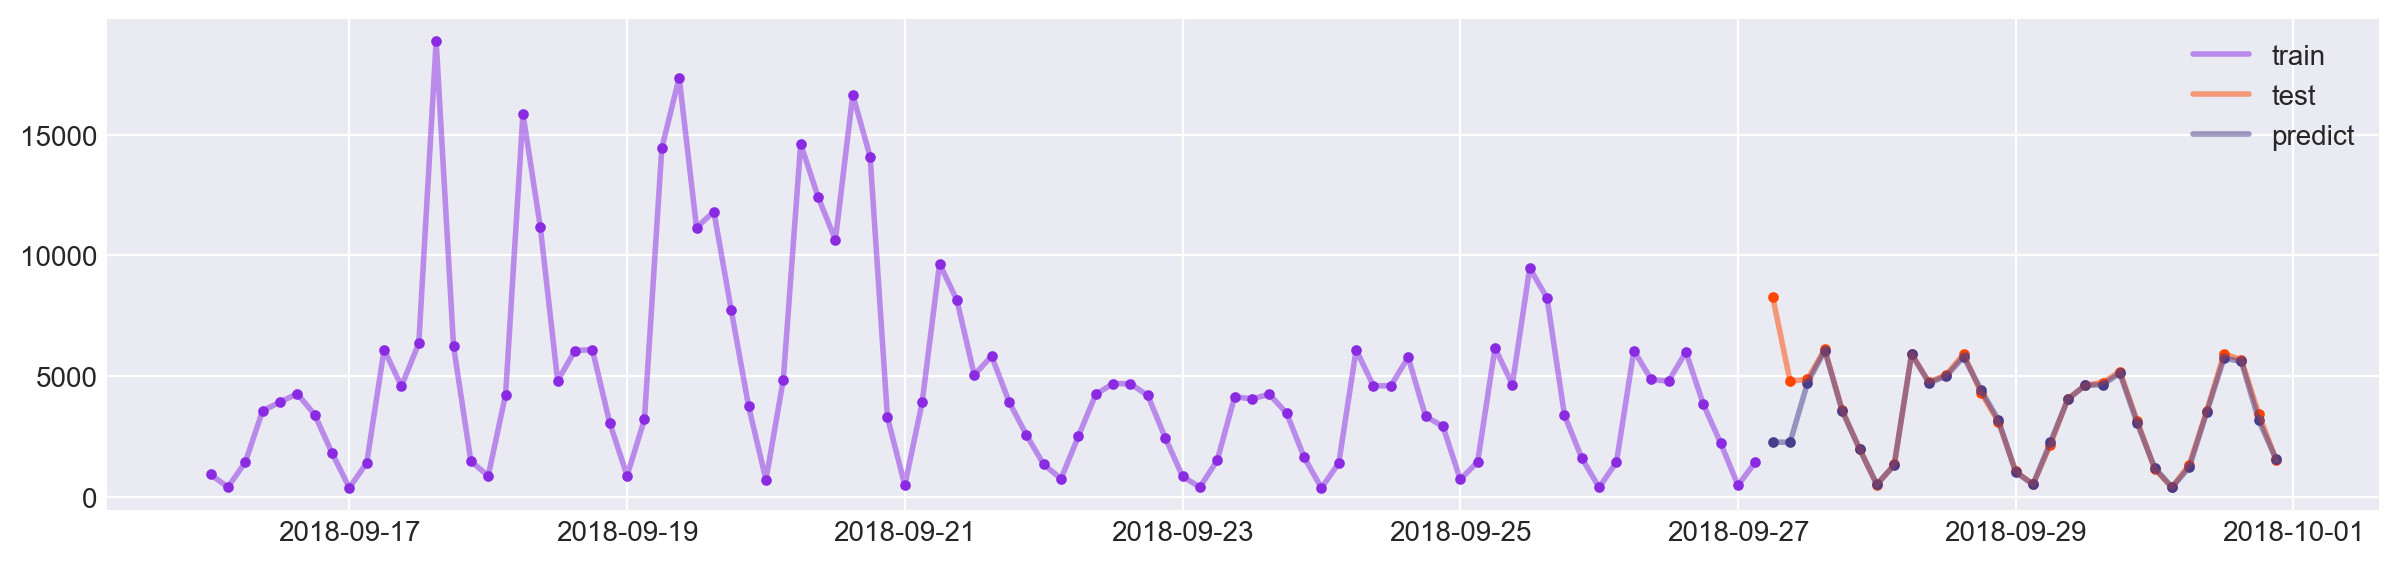

In [28]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [29]:
print(grid_search_results["params"])

{'l2_leaf_reg': 3}


In [30]:
del (
    train_data,
    test_data,
    train_data_feat,
    test_data_feat,
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 20

train_data, test_data = test_train_split(dataframe, test_size=WINDOW_LEN + 30)

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)


train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

x_window = np.concatenate([train_x, test_x])
y_window = np.concatenate([train_y, test_y])


x_window, y_window = window_data(x_window, y_window, window_len=WINDOW_LEN)

x_train_data, x_test_data = x_window[: -len(test_x)], x_window[-len(test_x) :]
y_train_data, y_test_data = y_window[: -len(test_x)], y_window[-len(test_x) :]

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

model = tf.keras.models.Sequential(
    [
        LSTM(128, input_shape=x_window.shape[-2:], dropout=0.0),
        Dense(128),
        Dense(128),
        Dense(1),
    ]
)

model.compile(optimizer="rmsprop", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=EPOCHS_,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

Epoch 1/20
200/200 [==============================] - 12s 46ms/step - loss: 7073015.5000 - mae: 1748.3740 - val_loss: 4469336.5000 - val_mae: 1705.3252
Epoch 2/20
200/200 [==============================] - 8s 42ms/step - loss: 2265369.5000 - mae: 924.1329 - val_loss: 1521935.1250 - val_mae: 942.9138
Epoch 3/20
200/200 [==============================] - 10s 50ms/step - loss: 821817.5000 - mae: 606.3744 - val_loss: 1246350.2500 - val_mae: 939.6282
Epoch 4/20
200/200 [==============================] - 10s 48ms/step - loss: 259576.2969 - mae: 327.5263 - val_loss: 204232.1562 - val_mae: 330.3611
Epoch 5/20
200/200 [==============================] - 10s 51ms/step - loss: 151898.5469 - mae: 263.2764 - val_loss: 204503.6875 - val_mae: 359.1806
Epoch 6/20
200/200 [==============================] - 10s 49ms/step - loss: 119640.4375 - mae: 242.2904 - val_loss: 294743.5938 - val_mae: 418.4106
Epoch 7/20
200/200 [==============================] - 10s 50ms/step - loss: 103387.6016 - mae: 223.8841 - 

In [32]:
resultsDict[model_name] = evaluate(y_test_data.flatten(), yhat.flatten())

predictionsDF[model_name] = yhat.flatten()[-len(predictionsDF.index) :]

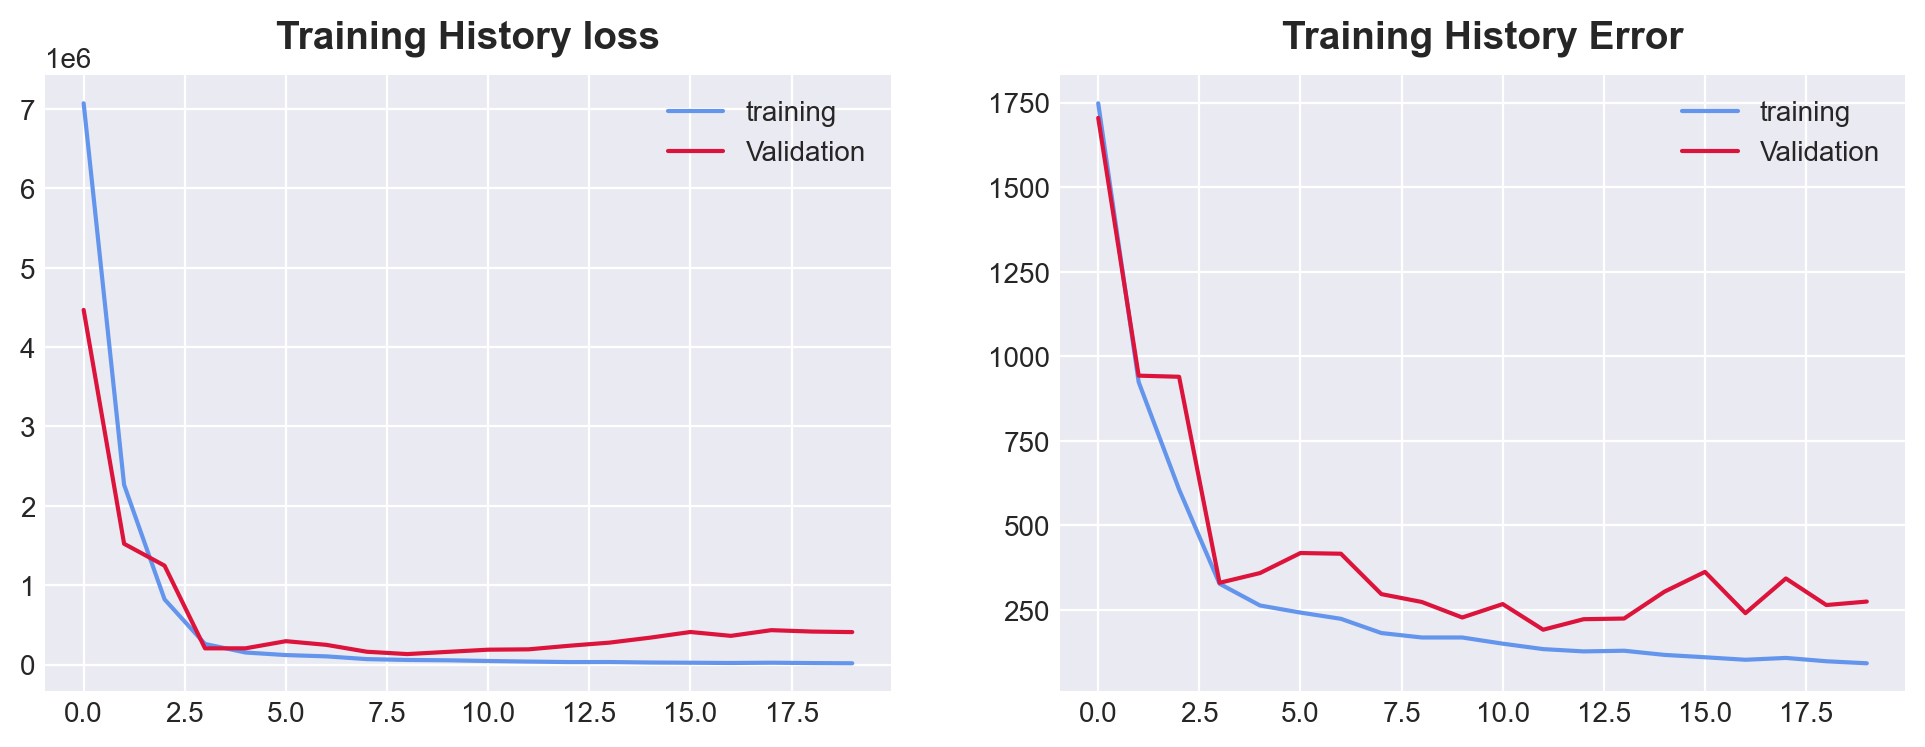

In [33]:
plot_tf_training_history(training_history)

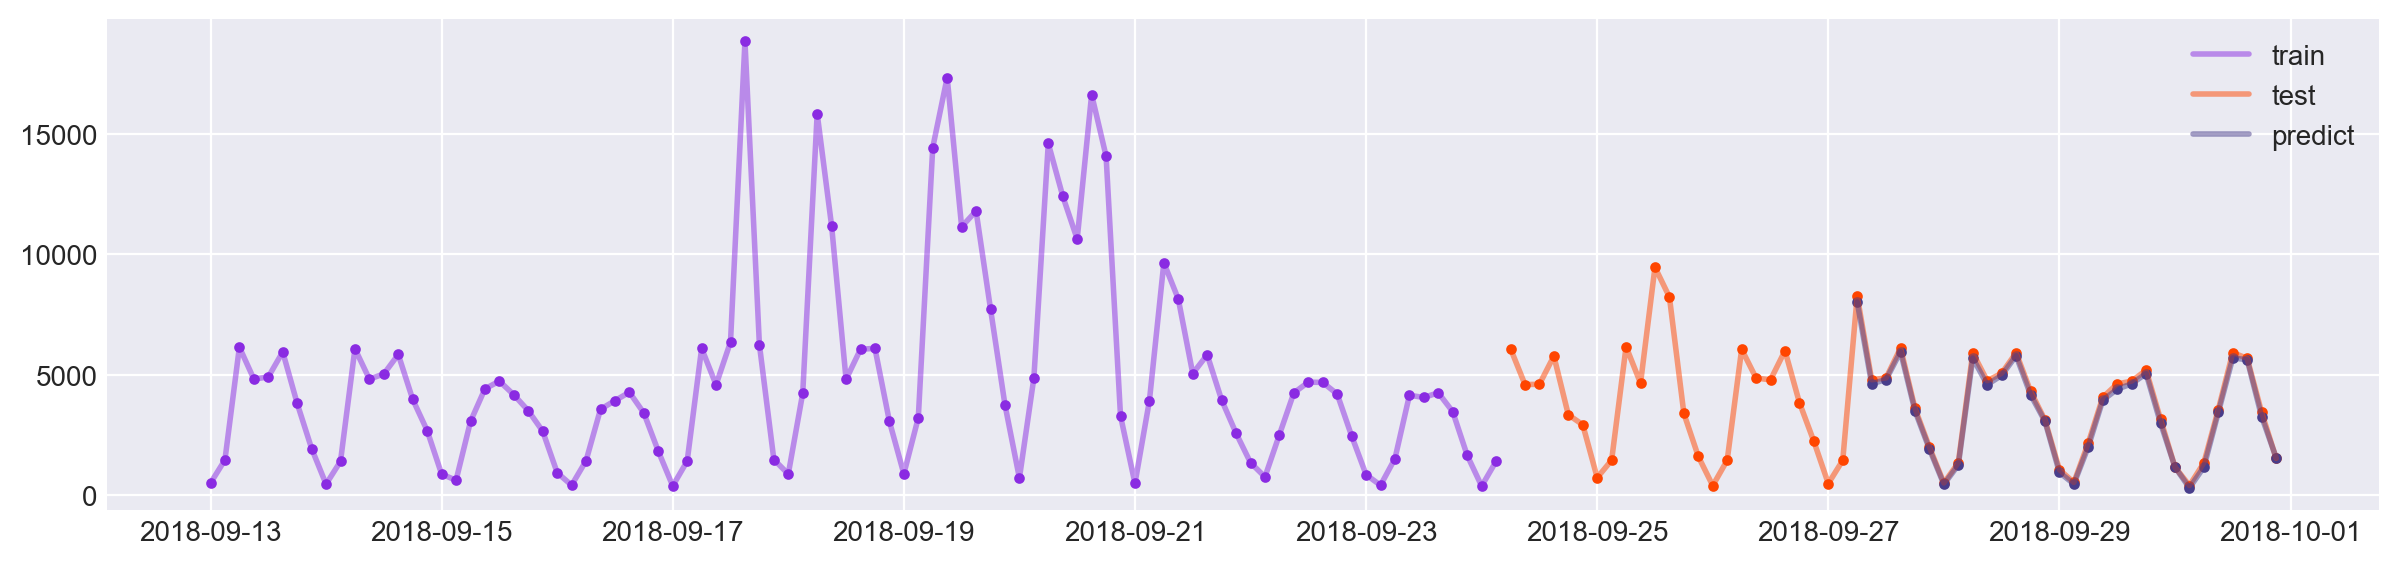

In [35]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [36]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,KNeighborsRegressor,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor,LSTM_Dense
mae,994.411111,343.533333,350.648790,281.899391,266.307650,268.536697,346.844184,274.894144
rmse,1249.175309,1404.551126,1394.461643,618.957945,823.536436,785.203357,1194.443405,639.630333
mape,0.492627,0.051558,0.057099,0.092725,0.061906,0.068250,0.063018,0.079650
r2,0.617127,0.515958,0.522888,0.906000,0.833592,0.848723,0.649943,0.915400


In [37]:
resultsDF.T

,mae,rmse,mape,r2
KNeighborsRegressor,994.411111,1249.175309,0.492627,0.617127
BayesianRidge,343.533333,1404.551126,0.051558,0.515958
LassoCV,350.648790,1394.461643,0.057099,0.522888
RandomForestRegressor,281.899391,618.957945,0.092725,0.906000
XGBRegressor,266.307650,823.536436,0.061906,0.833592
LGBMRegressor,268.536697,785.203357,0.068250,0.848723
CatBoostRegressor,346.844184,1194.443405,0.063018,0.649943
LSTM_Dense,274.894144,639.630333,0.079650,0.915400


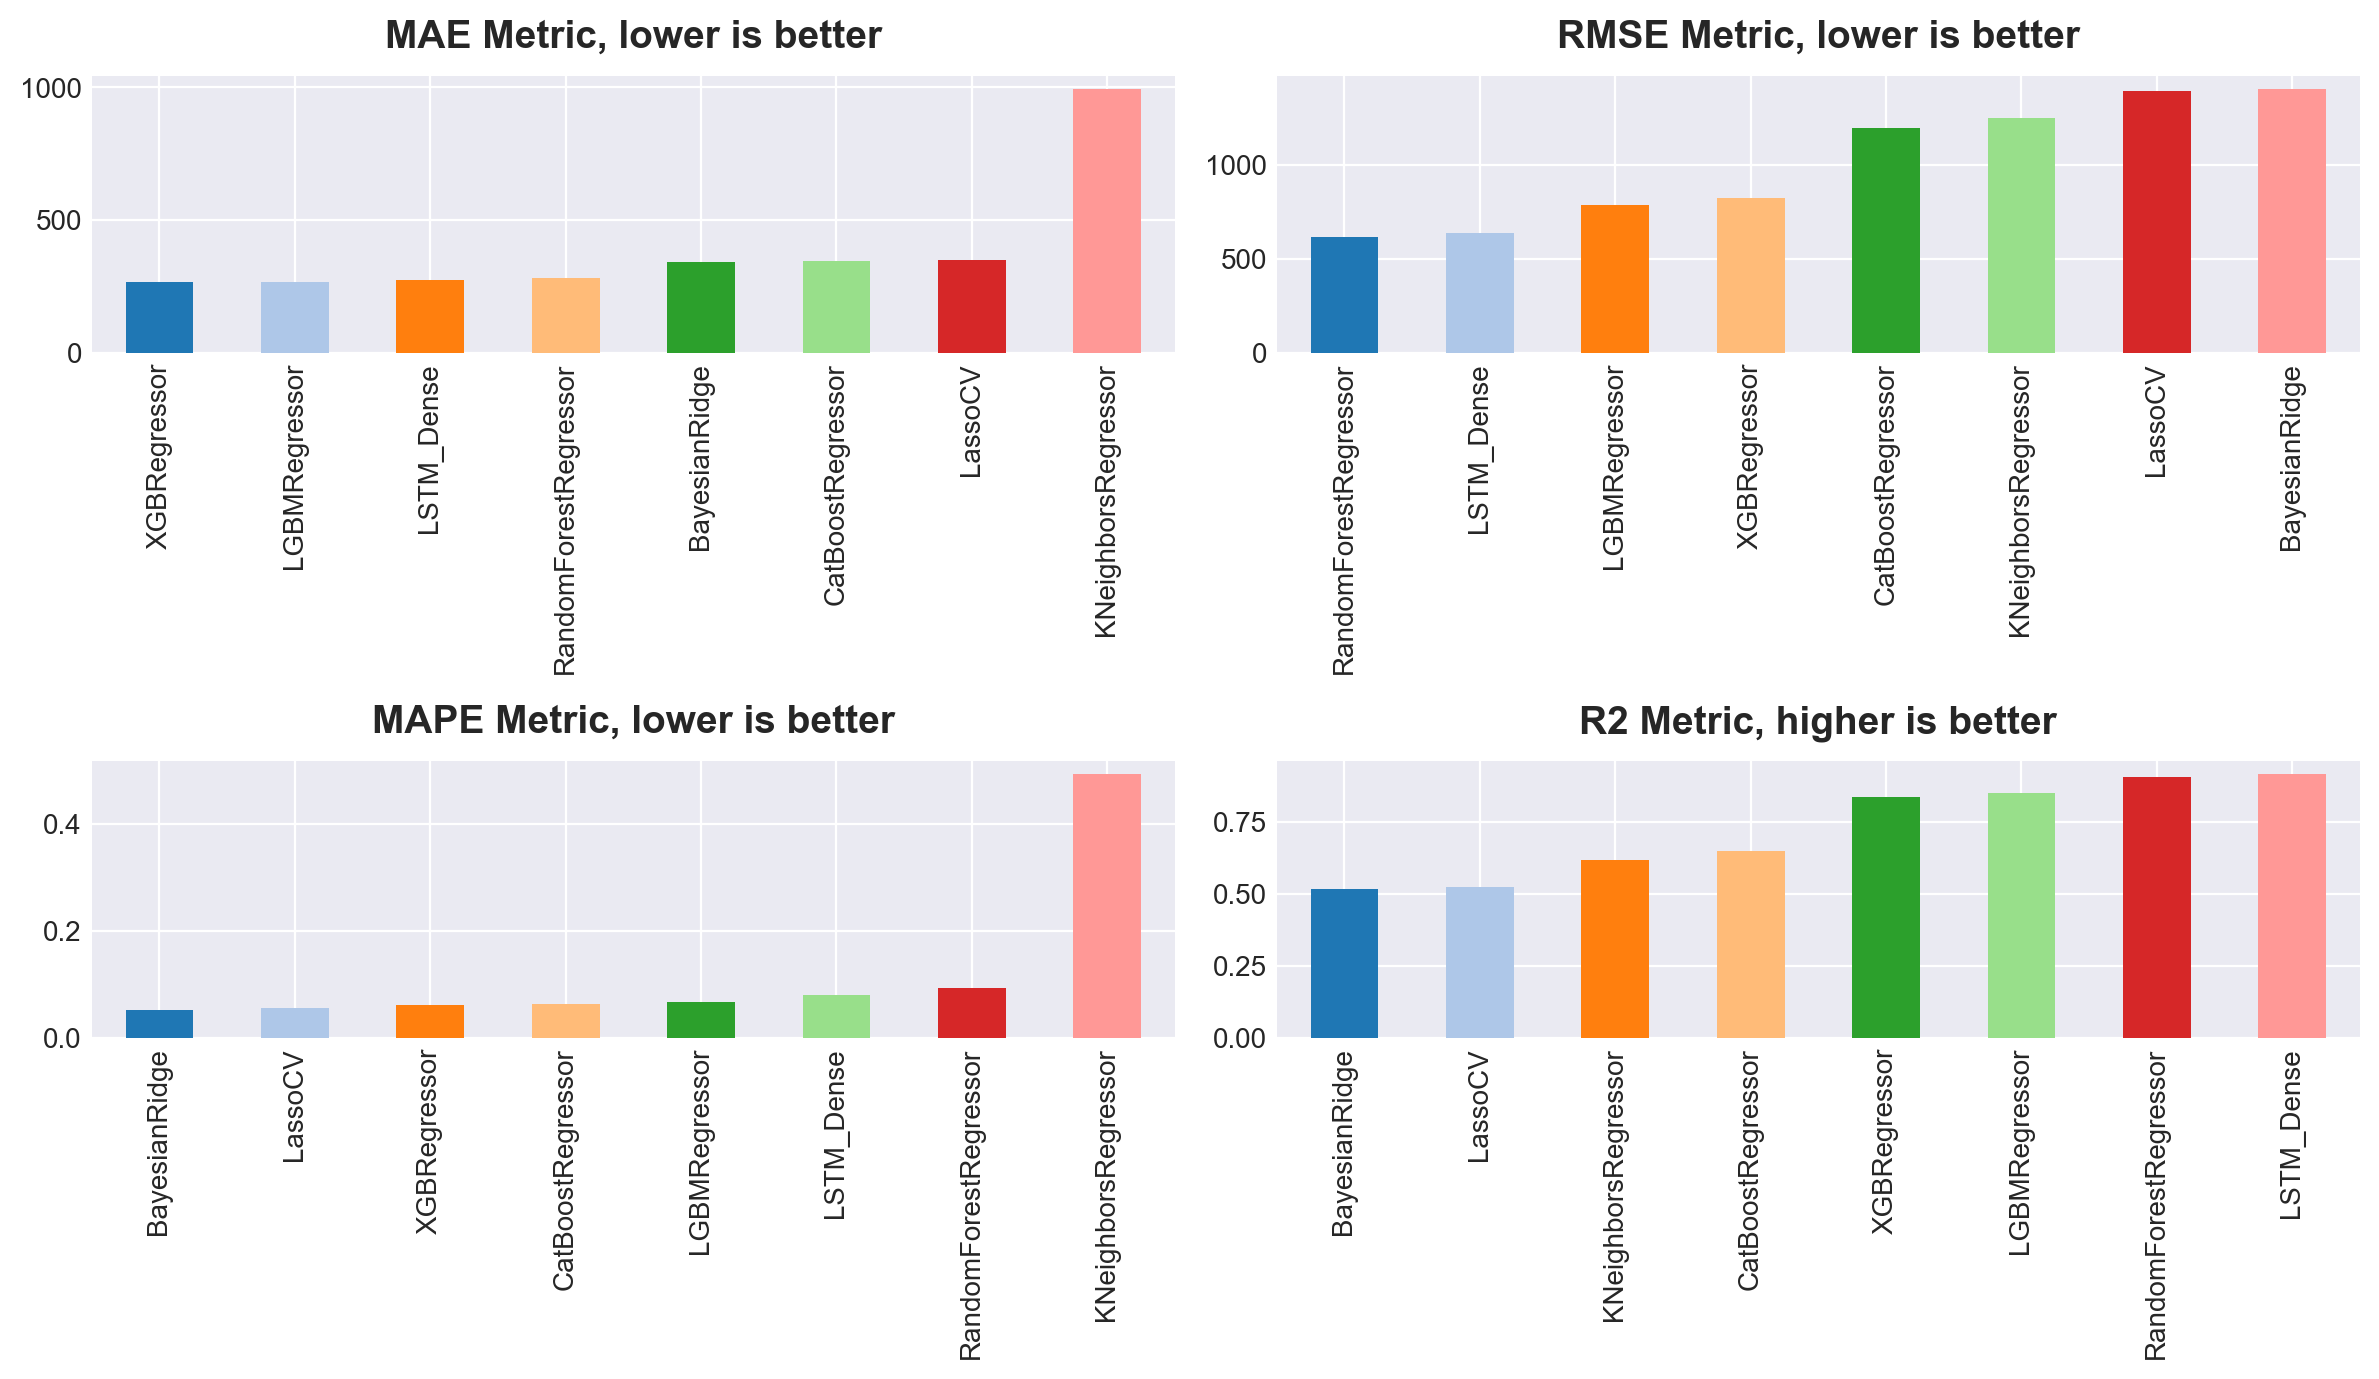

In [38]:
plot_metrics(resultsDF)

### Saving results

In [39]:
resultsDF_T = resultsDF.T.copy(deep=True)
resultsDF_T["Dataset"] = "Traffic"
resultsDF_T["Mode"] = "Singel_step"

result_path = "./results/results.csv"

if os.path.isfile(result_path) is False:
    resultsDF_T.to_csv(result_path, index=False)
else:
    result_data = pd.read_csv(result_path)
    if result_data[result_data["Dataset"] == "Traffic"].shape[0] > 0:
        result_data = result_data[result_data["Dataset"] != "Traffic"].copy()

    new_data = pd.concat([result_data, resultsDF_T])
    new_data.to_csv(result_path, index=False)